In [134]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [135]:
import os
# Get the current working directory
current_dir = os.getcwd()
# Navigate to the parent folder
parent_dir = os.path.dirname(current_dir)


In [136]:
file_path = os.path.join(parent_dir, 'Final_ML_Table.csv')
ml_df = pd.read_csv(file_path)

### Preparing the data for modelling

In [137]:
# Dropping rows where imputation is not possible
clean_df = ml_df.dropna(subset=['ACTUAL', 'ggroup', 'Target_binary', 'Earnings_Surprise', 'mkvaltq', 'cshoc']).copy()
# Imputing mean for the rest of the missing values for columns atq and ibq based on the ggroup
clean_df.loc[:,['atq', 'ibq']] = clean_df.groupby('ggroup')[['atq', 'ibq']].transform(lambda x: x.fillna(x.mean()))
# Computing market cap
clean_df['market_cap'] = clean_df['cshoc'] * clean_df['nonadjclose']
# Scaling next quarter earnings by market cap
clean_df.loc[:,'Scaled_nextq_earnings'] = clean_df.loc[:,'Next_quarter_earnings'] / clean_df.loc[:,'market_cap']
# Creating an interaction term between positive and negative sentiment and buzzscore
clean_df.loc[:,'Positive_buzzscore'] = clean_df.loc[:,'Positive'] * clean_df.loc[:,'buzzscore']
clean_df.loc[:,'Negative_buzzscore'] = clean_df.loc[:,'Negative'] * clean_df.loc[:,'buzzscore']
# Creating an interaction term between buzzscore and Positive and Negative Counts
clean_df.loc[:,'Positive_buzzscore_count'] = clean_df.loc[:,'Positive_count'] * clean_df.loc[:,'buzzscore']
clean_df.loc[:,'Negative_buzzscore_count'] = clean_df.loc[:,'Negative_count'] * clean_df.loc[:,'buzzscore']
# Creating all the same interaction terms but with buzzcount instead of buzzscore
clean_df.loc[:,'Positive_buzzcount'] = clean_df.loc[:,'Positive'] * clean_df.loc[:,'buzzcount']
clean_df.loc[:,'Negative_buzzcount'] = clean_df.loc[:,'Negative'] * clean_df.loc[:,'buzzcount']
clean_df.loc[:,'Positive_buzzcount_count'] = clean_df.loc[:,'Positive_count'] * clean_df.loc[:,'buzzcount']
clean_df.loc[:,'Negative_buzzcount_count'] = clean_df.loc[:,'Negative_count'] * clean_df.loc[:,'buzzcount']

In [138]:
clean_df = pd.get_dummies(clean_df, columns=['ggroup', 'Sentiment'], drop_first=True)

In [139]:
# Get all column names after get_dummies
all_columns = clean_df.columns.tolist()

# Get dummy column names for 'ggroup'
ggroup_columns = [col for col in all_columns if 'ggroup' in col]

In [140]:
# exog_vars_1 is a list of explanatory variables for the first model. 
# It includes various financial and sentiment metrics, as well as industry dummy variables.
exog_vars_1 = ['buzzscore', 'atq', 'ibq', 'Earnings_Surprise', 'nonadjclose','cshoc', 'Positive_buzzscore', 'Positive', 'Negative_buzzscore',
              'Negative', 'Uncertainty', 'Litigious', 'Constraining', 'Weak_Modal', 'Strong_Modal', 'total_tokens', 
              'ggroup_Banks', 'ggroup_Capital Goods', 'ggroup_Commercial & Professional Services', 
              'ggroup_Consumer Durables & Apparel', 'ggroup_Consumer Services', 'ggroup_Diversified Financials', 
              'ggroup_Energy', 'ggroup_Food & Staples Retailing', 'ggroup_Food, Beverage & Tobacco', 
              'ggroup_Health Care Equipment & Services', 'ggroup_Household & Personal Products', 'ggroup_Insurance', 
              'ggroup_Materials', 'ggroup_Media & Entertainment', 'ggroup_Pharmaceuticals, Biotechnology & Life Sciences', 
              'ggroup_Real Estate', 'ggroup_Retailing', 'ggroup_Semiconductors & Semiconductor Equipment', 'ggroup_Software & Services', 
              'ggroup_Technology Hardware & Equipment', 'ggroup_Telecommunication Services', 'ggroup_Transportation', 'ggroup_Utilities']

# exog_vars_2 is a list of explanatory variables for the second model. 
# It is similar to exog_vars_1 but replaces some variables with their count versions.
exog_vars_2 = ['buzzscore', 'atq', 'ibq', 'Earnings_Surprise', 'nonadjclose', 'cshoc', 'Positive_buzzscore_count', 'Positive_count',
                'Negative_buzzscore_count', 'Negative_count', 'Uncertainty_count', 'total_tokens',
                'ggroup_Banks', 'ggroup_Capital Goods', 'ggroup_Commercial & Professional Services', 
              'ggroup_Consumer Durables & Apparel', 'ggroup_Consumer Services', 'ggroup_Diversified Financials', 
              'ggroup_Energy', 'ggroup_Food & Staples Retailing', 'ggroup_Food, Beverage & Tobacco', 
              'ggroup_Health Care Equipment & Services', 'ggroup_Household & Personal Products', 'ggroup_Insurance', 
              'ggroup_Materials', 'ggroup_Media & Entertainment', 'ggroup_Pharmaceuticals, Biotechnology & Life Sciences', 
              'ggroup_Real Estate', 'ggroup_Retailing', 'ggroup_Semiconductors & Semiconductor Equipment', 'ggroup_Software & Services', 
              'ggroup_Technology Hardware & Equipment', 'ggroup_Telecommunication Services', 'ggroup_Transportation', 'ggroup_Utilities']

# exog_vars_3 is a list of explanatory variables for the third model. 
# It is similar to exog_vars_1 but replaces 'buzzscore' with 'buzzcount'.
exog_vars_3 = ['buzzcount', 'atq', 'ibq', 'Earnings_Surprise', 'nonadjclose', 'cshoc', 'Positive_buzzcount', 'Positive', 'Negative_buzzcount',
              'Negative', 'Uncertainty', 'Litigious', 'Constraining', 'Weak_Modal', 'Strong_Modal', 'total_tokens',
              'ggroup_Banks', 'ggroup_Capital Goods', 'ggroup_Commercial & Professional Services', 
              'ggroup_Consumer Durables & Apparel', 'ggroup_Consumer Services', 'ggroup_Diversified Financials', 
              'ggroup_Energy', 'ggroup_Food & Staples Retailing', 'ggroup_Food, Beverage & Tobacco', 
              'ggroup_Health Care Equipment & Services', 'ggroup_Household & Personal Products', 'ggroup_Insurance', 
              'ggroup_Materials', 'ggroup_Media & Entertainment', 'ggroup_Pharmaceuticals, Biotechnology & Life Sciences', 
              'ggroup_Real Estate', 'ggroup_Retailing', 'ggroup_Semiconductors & Semiconductor Equipment', 'ggroup_Software & Services', 
              'ggroup_Technology Hardware & Equipment', 'ggroup_Telecommunication Services', 'ggroup_Transportation', 'ggroup_Utilities']

# exog_vars_4 is a list of explanatory variables for the fourth model. 
# It is similar to exog_vars_3 but replaces some variables with their count versions.
exog_vars_4 = ['buzzcount', 'atq', 'ibq', 'Earnings_Surprise', 'nonadjclose', 'cshoc', 'Positive_buzzcount_count', 'Positive_count',
                'Negative_buzzcount_count', 'Negative_count', 'Uncertainty_count', 'total_tokens',
                'ggroup_Banks', 'ggroup_Capital Goods', 'ggroup_Commercial & Professional Services', 
              'ggroup_Consumer Durables & Apparel', 'ggroup_Consumer Services', 'ggroup_Diversified Financials', 
              'ggroup_Energy', 'ggroup_Food & Staples Retailing', 'ggroup_Food, Beverage & Tobacco', 
              'ggroup_Health Care Equipment & Services', 'ggroup_Household & Personal Products', 'ggroup_Insurance', 
              'ggroup_Materials', 'ggroup_Media & Entertainment', 'ggroup_Pharmaceuticals, Biotechnology & Life Sciences', 
              'ggroup_Real Estate', 'ggroup_Retailing', 'ggroup_Semiconductors & Semiconductor Equipment', 'ggroup_Software & Services', 
              'ggroup_Technology Hardware & Equipment', 'ggroup_Telecommunication Services', 'ggroup_Transportation', 'ggroup_Utilities']

In [141]:
# exog_vars_1 is a list of explanatory variables for the first model. 
# It includes various financial and sentiment metrics, as well as industry dummy variables.
ensemble_vars_1 = ['buzzscore', 'atq', 'ibq', 'Earnings_Surprise', 'nonadjclose', 'Positive',
              'Negative', 'Uncertainty', 'Litigious', 'Constraining', 'Weak_Modal', 'Strong_Modal', 'total_tokens', 
              'ggroup_Banks', 'ggroup_Capital Goods', 'ggroup_Commercial & Professional Services', 
              'ggroup_Consumer Durables & Apparel', 'ggroup_Consumer Services', 'ggroup_Diversified Financials', 
              'ggroup_Energy', 'ggroup_Food & Staples Retailing', 'ggroup_Food, Beverage & Tobacco', 
              'ggroup_Health Care Equipment & Services', 'ggroup_Household & Personal Products', 'ggroup_Insurance', 
              'ggroup_Materials', 'ggroup_Media & Entertainment', 'ggroup_Pharmaceuticals, Biotechnology & Life Sciences', 
              'ggroup_Real Estate', 'ggroup_Retailing', 'ggroup_Semiconductors & Semiconductor Equipment', 'ggroup_Software & Services', 
              'ggroup_Technology Hardware & Equipment', 'ggroup_Telecommunication Services', 'ggroup_Transportation', 'ggroup_Utilities',
              'cshoc']

# exog_vars_2 is a list of explanatory variables for the second model. 
ensemble_vars_2 = ['buzzscore', 'atq', 'ibq', 'Earnings_Surprise', 'nonadjclose','cshoc', 'Positive_count',
                 'Negative_count', 'Uncertainty_count', 'total_tokens',
                'ggroup_Banks', 'ggroup_Capital Goods', 'ggroup_Commercial & Professional Services', 
              'ggroup_Consumer Durables & Apparel', 'ggroup_Consumer Services', 'ggroup_Diversified Financials', 
              'ggroup_Energy', 'ggroup_Food & Staples Retailing', 'ggroup_Food, Beverage & Tobacco', 
              'ggroup_Health Care Equipment & Services', 'ggroup_Household & Personal Products', 'ggroup_Insurance', 
              'ggroup_Materials', 'ggroup_Media & Entertainment', 'ggroup_Pharmaceuticals, Biotechnology & Life Sciences', 
              'ggroup_Real Estate', 'ggroup_Retailing', 'ggroup_Semiconductors & Semiconductor Equipment', 'ggroup_Software & Services', 
              'ggroup_Technology Hardware & Equipment', 'ggroup_Telecommunication Services', 'ggroup_Transportation', 'ggroup_Utilities']

# exog_vars_3 is a list of explanatory variables for the third model. 
# It is similar to exog_vars_1 but replaces 'buzzscore' with 'buzzcount'.
ensemble_vars_3 = ['buzzcount', 'atq', 'ibq', 'Earnings_Surprise', 'nonadjclose', 'cshoc', 'Positive',
              'Negative', 'Uncertainty', 'Litigious', 'Constraining', 'Weak_Modal', 'Strong_Modal', 'total_tokens',
              'ggroup_Banks', 'ggroup_Capital Goods', 'ggroup_Commercial & Professional Services', 
              'ggroup_Consumer Durables & Apparel', 'ggroup_Consumer Services', 'ggroup_Diversified Financials', 
              'ggroup_Energy', 'ggroup_Food & Staples Retailing', 'ggroup_Food, Beverage & Tobacco', 
              'ggroup_Health Care Equipment & Services', 'ggroup_Household & Personal Products', 'ggroup_Insurance', 
              'ggroup_Materials', 'ggroup_Media & Entertainment', 'ggroup_Pharmaceuticals, Biotechnology & Life Sciences', 
              'ggroup_Real Estate', 'ggroup_Retailing', 'ggroup_Semiconductors & Semiconductor Equipment', 'ggroup_Software & Services', 
              'ggroup_Technology Hardware & Equipment', 'ggroup_Telecommunication Services', 'ggroup_Transportation', 'ggroup_Utilities']

# exog_vars_4 is a list of explanatory variables for the fourth model. 
# It is similar to exog_vars_3 but replaces some variables with their count versions.
ensemble_vars_4 = ['buzzcount', 'atq', 'ibq', 'Earnings_Surprise', 'nonadjclose', 'cshoc',  'Positive_count',
                 'Negative_count', 'Uncertainty_count', 'total_tokens',
                'ggroup_Banks', 'ggroup_Capital Goods', 'ggroup_Commercial & Professional Services', 
              'ggroup_Consumer Durables & Apparel', 'ggroup_Consumer Services', 'ggroup_Diversified Financials', 
              'ggroup_Energy', 'ggroup_Food & Staples Retailing', 'ggroup_Food, Beverage & Tobacco', 
              'ggroup_Health Care Equipment & Services', 'ggroup_Household & Personal Products', 'ggroup_Insurance', 
              'ggroup_Materials', 'ggroup_Media & Entertainment', 'ggroup_Pharmaceuticals, Biotechnology & Life Sciences', 
              'ggroup_Real Estate', 'ggroup_Retailing', 'ggroup_Semiconductors & Semiconductor Equipment', 'ggroup_Software & Services', 
              'ggroup_Technology Hardware & Equipment', 'ggroup_Telecommunication Services', 'ggroup_Transportation', 'ggroup_Utilities']

In [142]:
# Related sets but without the buzzscore and buzzcount variables but with sentiment
exog_vars_no_buzz_1 = [var for var in exog_vars_1 if var not in ['buzzscore', 'Positive_buzzscore', 'Negative_buzzscore']]

exog_vars_no_buzz_2 = [var for var in exog_vars_2 if var not in ['buzzscore', 'Positive_buzzscore_count', 'Negative_buzzscore_count']]

exog_vars_nosent_nobuzz = [var for var in exog_vars_no_buzz_1 if var not in ['Positive', 'Negative', 'Uncertainty', 'Litigious', 
                                                                             'Constraining', 'Weak_Modal', 'Strong_Modal', 'total_tokens']]

#variables for ensemble model
ensemble_vars_no_buzz_1 = [var for var in ensemble_vars_1 if var not in ['buzzscore', 'Positive_buzzscore', 'Negative_buzzscore']]

ensemble_vars_no_buzz_2 = [var for var in ensemble_vars_2 if var not in ['buzzscore', 'Positive_buzzscore_count', 'Negative_buzzscore_count']]

ensemble_vars_nosent_nobuzz = [var for var in ensemble_vars_no_buzz_1 if var not in ['Positive', 'Negative', 'Uncertainty', 'Litigious', 
                                                                             'Constraining', 'Weak_Modal', 'Strong_Modal', 'total_tokens']]
 

In [143]:
# Checking the distribution of the target variable
distribution = clean_df.groupby('datacqtr')['Target_binary'].value_counts(normalize=True)

# Print the distribution
print(distribution)

datacqtr  Target_binary
2009Q1    Buy              0.666667
          Sell             0.333333
2009Q2    Buy              0.681327
          Sell             0.318673
2009Q3    Buy              0.650345
                             ...   
2021Q3    Buy              0.257349
2021Q4    Sell             0.730221
          Buy              0.269779
2022Q1    Buy              0.500000
          Sell             0.500000
Name: proportion, Length: 106, dtype: float64


In [144]:
# Remove 2009Q1 and 2022Q2 data
clean_df = clean_df[(clean_df['datacqtr'] != '2009Q1') & (clean_df['datacqtr'] != '2022Q2')]

In [145]:
# Taking out data from 2021Q2 untill 2022Q1 for testing
train_df = clean_df[(clean_df['datacqtr'] < '2021Q2') & (clean_df['datacqtr'] > '2009Q1')].copy()
test_df = clean_df[(clean_df['datacqtr'] >= '2021Q2') & (clean_df['datacqtr'] <= '2022Q1')].copy()
train_df = train_df.reset_index(drop=True)
clean_df = clean_df.reset_index(drop=True)

y_train = train_df['Target_binary']

X_1 = train_df[exog_vars_1]
X_2 = train_df[exog_vars_2]
X_3 = train_df[exog_vars_3]
X_4 = train_df[exog_vars_4]

X_nobuzz_1 = train_df[exog_vars_no_buzz_1]
X_nobuzz_2 = train_df[exog_vars_no_buzz_2]

X_nosent_nobuzz = train_df[exog_vars_nosent_nobuzz]

X_ensemble_1 = train_df[ensemble_vars_1]
X_ensemble_2 = train_df[ensemble_vars_2]
X_ensemble_3 = train_df[ensemble_vars_3]
X_ensemble_4 = train_df[ensemble_vars_4]

X_ensemble_nobuzz_1 = train_df[ensemble_vars_no_buzz_1]
X_ensemble_nobuzz_2 = train_df[ensemble_vars_no_buzz_2]

X_ensemble_nosent_nobuzz = train_df[ensemble_vars_nosent_nobuzz]

In [146]:
y_full = clean_df['Target_binary']
X_1_full = clean_df[exog_vars_1]
X_2_full = clean_df[exog_vars_2]
X_3_full = clean_df[exog_vars_3]
X_4_full = clean_df[exog_vars_4]

X_nobuzz_1_full = clean_df[exog_vars_no_buzz_1]
X_nobuzz_2_full = clean_df[exog_vars_no_buzz_2]

X_nosent_nobuzz_full = clean_df[exog_vars_nosent_nobuzz]

X_ensemble_1_full = clean_df[ensemble_vars_1]
X_ensemble_2_full = clean_df[ensemble_vars_2]
X_ensemble_3_full = clean_df[ensemble_vars_3]
X_ensemble_4_full = clean_df[ensemble_vars_4]

X_ensemble_nobuzz_1_full = clean_df[ensemble_vars_no_buzz_1]
X_ensemble_nobuzz_2_full = clean_df[ensemble_vars_no_buzz_2]

X_ensemble_nosent_nobuzz_full = clean_df[ensemble_vars_nosent_nobuzz]

In [147]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform the y_train
y_train_encoded = le.fit_transform(y_train)
y_full_encoded = le.fit_transform(y_full)

#### Only for the Logistic regression

In [109]:
# Create a StandardScaler instance
scaler = StandardScaler()

# List of dataframes to scale
dfs = [X_1, X_2, X_3, X_4, X_nobuzz_1, X_nobuzz_2, X_nosent_nobuzz]

# Exclude columns that are already proportions
exclude_cols = ['Positive', 'Negative', 'Uncertainty', 'Constraining', 'Litigious', 'Weak_Modal', 'Strong_Modal']

for df in dfs:
    # Select numeric columns excluding the specified ones
    numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in exclude_cols]
    df.loc[:, numeric_cols] = scaler.fit_transform(df.loc[:, numeric_cols])

### Tuning the L1 logistic regression model

In [105]:
splits = []
unique_datacqtr = train_df['datacqtr'].unique()

# Ensure there are at least 4 quarters
assert len(unique_datacqtr) >= 4, "Not enough quarters for splitting"

for i in range(0, len(unique_datacqtr)-4):
    # Use all quarters up to i+4 for training
    train = train_df[train_df['datacqtr'].isin(unique_datacqtr[:i+4])]
    train_index = train.index.to_numpy()
    # Use the next quarter for testing
    test = train_df[train_df['datacqtr'] == unique_datacqtr[i+4]]
    test_index = test.index.to_numpy()
    if not test.empty:  # Ensure there is data in the test set
        splits.append((train_index, test_index))

In [106]:
# Define the model
model = LogisticRegression(penalty='l1', solver='saga', max_iter=10000, random_state=42, n_jobs=-2, class_weight='balanced')
# Define the hyperparameter grid
param_grid = {'C': [0.01, 0.1, 0.5, 1, 1.5, 10, 100]}

# Define the grid search
grid_search = GridSearchCV(model, param_grid, cv=splits, scoring='accuracy', n_jobs=-2, verbose=3)

In [102]:
# Fit the grid search
grid_search.fit(X_1, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 44 folds for each of 8 candidates, totalling 352 fits
Best parameters:  {'C': 10}
Best cross-validation score:  0.528249392942305


In [103]:
# Fit the grid search
grid_search.fit(X_2, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 44 folds for each of 8 candidates, totalling 352 fits
Best parameters:  {'C': 100}
Best cross-validation score:  0.5242094320136794


In [104]:
# Fit the grid search
grid_search.fit(X_3, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 44 folds for each of 8 candidates, totalling 352 fits
Best parameters:  {'C': 10}
Best cross-validation score:  0.5291387058083412


In [105]:
# Fit the grid search
grid_search.fit(X_4, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 44 folds for each of 8 candidates, totalling 352 fits
Best parameters:  {'C': 100}
Best cross-validation score:  0.5254149189373876


Best cross-validation score:  0.5248289865918653


Tuning the no buzzword features model

In [110]:
# Fit the grid search
grid_search.fit(X_nobuzz_1, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 44 folds for each of 7 candidates, totalling 308 fits
Best parameters:  {'C': 100}
Best cross-validation score:  0.5303519843346428


In [107]:
# Fit the grid search
grid_search.fit(X_nobuzz_2, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 44 folds for each of 8 candidates, totalling 352 fits
Best parameters:  {'C': 0.5}
Best cross-validation score:  0.5267014088149732


No Buzz no sentiment

In [111]:
# Fit the grid search
grid_search.fit(X_nosent_nobuzz, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 44 folds for each of 7 candidates, totalling 308 fits
Best parameters:  {'C': 0.1}
Best cross-validation score:  0.5323916710442841


### Tuning the random forest model

In [15]:
splits_rf = []
unique_datacqtr = train_df['datacqtr'].unique()

# Ensure there are at least 8 quarters
assert len(unique_datacqtr) >= 8, "Not enough quarters for splitting"

for i in range(0, len(unique_datacqtr)-7, 4):
    # Use all quarters up to i+4 for training
    train = train_df[train_df['datacqtr'].isin(unique_datacqtr[:i+4])]
    train_index = train.index.to_numpy()
    # Use the next 4 quarters for testing
    test = train_df[train_df['datacqtr'].isin(unique_datacqtr[i+4:i+8])]
    test_index = test.index.to_numpy()
    if not test.empty:  # Ensure there is data in the test set
        splits_rf.append((train_index, test_index))

In [16]:
# Define the model
model = RandomForestClassifier(random_state=42, n_jobs=4, class_weight='balanced')
# Define the hyperparameter grd
param_grid = {'n_estimators': [300, 600, 1000, 1500],
              'max_depth': [10, 25,30],
              'min_samples_split': [2, 5]
              }

# Define the grid search
grid_search = GridSearchCV(model, param_grid, cv=splits_rf, scoring='accuracy', n_jobs=4, verbose=3)

In [17]:
# Fit the grid search
grid_search.fit(X_ensemble_1, y_train_encoded)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 11 folds for each of 24 candidates, totalling 264 fits
Best parameters:  {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 1000}
Best cross-validation score:  0.5740346406285428


In [18]:
# Fit the grid search
grid_search.fit(X_ensemble_2, y_train_encoded)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 11 folds for each of 24 candidates, totalling 264 fits
Best parameters:  {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 1000}
Best cross-validation score:  0.568016127429388


In [19]:
# Fit the grid search
grid_search.fit(X_ensemble_3, y_train_encoded)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 11 folds for each of 24 candidates, totalling 264 fits
Best parameters:  {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 1500}
Best cross-validation score:  0.5742090410660958


In [20]:
# Fit the grid search
grid_search.fit(X_ensemble_4, y_train_encoded)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 11 folds for each of 24 candidates, totalling 264 fits
Best parameters:  {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 1500}
Best cross-validation score:  0.5675465040193881


Tuning the no buzzword models

In [21]:
# Fit the grid search
grid_search.fit(X_ensemble_nobuzz_1, y_train_encoded)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 11 folds for each of 24 candidates, totalling 264 fits
Best parameters:  {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 1000}
Best cross-validation score:  0.5742639455236641


In [22]:
# Fit the grid search
grid_search.fit(X_ensemble_nobuzz_2, y_train_encoded)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 11 folds for each of 24 candidates, totalling 264 fits


Best parameters:  {'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 600}
Best cross-validation score:  0.5666728421164624


No buzzwords and no sentiment

In [23]:
# Fit the grid search
grid_search.fit(X_ensemble_nosent_nobuzz, y_train_encoded)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 11 folds for each of 24 candidates, totalling 264 fits
Best parameters:  {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 600}
Best cross-validation score:  0.5618622880865571


### Tuning the XGBoost model

In [44]:
# Create a StandardScaler instance
scaler = StandardScaler()

# List of dataframes to scale
dfs = [X_ensemble_1, X_ensemble_2, X_ensemble_3, X_ensemble_4, X_ensemble_nobuzz_1, X_ensemble_nobuzz_2, X_ensemble_nosent_nobuzz]

# Exclude columns that are already proportions
exclude_cols = ['Positive', 'Negative', 'Uncertainty', 'Constraining', 'Litigious', 'Weak_Modal', 'Strong_Modal']

for df in dfs:
    # Select numeric columns excluding the specified ones
    numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in exclude_cols]
    df.loc[:, numeric_cols] = scaler.fit_transform(df.loc[:, numeric_cols])

In [45]:
# Count buy and sell samples
num_buy = sum(y_train_encoded == 0)
num_sell = sum(y_train_encoded == 1)

# Calculate scale_pos_weight
scale_pos_weight = num_buy / num_sell

In [46]:
# Define the model
model = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss', 
                      verbosity=2, random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [300, 600, 1000],
    'max_depth': [2, 3],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Define the grid search
grid_search = GridSearchCV(model, param_grid, cv=splits_rf, scoring='accuracy', n_jobs=-2, verbose=3)

In [47]:
# Fit the grid search
grid_search.fit(X_ensemble_1, y_train_encoded)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 11 folds for each of 54 candidates, totalling 594 fits
Best parameters:  {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300}
Best cross-validation score:  0.5612023268828211


In [48]:
# Fit the grid search
grid_search.fit(X_ensemble_2, y_train_encoded)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 11 folds for each of 54 candidates, totalling 594 fits
Best parameters:  {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Best cross-validation score:  0.560662425143773


In [49]:
# Fit the grid search
grid_search.fit(X_ensemble_3, y_train_encoded)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 11 folds for each of 54 candidates, totalling 594 fits
Best parameters:  {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Best cross-validation score:  0.5622267349041393


In [50]:
# Fit the grid search
grid_search.fit(X_ensemble_4, y_train_encoded)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 11 folds for each of 54 candidates, totalling 594 fits
Best parameters:  {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Best cross-validation score:  0.5620833511255126


No buzzword measures

In [51]:
# Fit the grid search
grid_search.fit(X_ensemble_nobuzz_1, y_train_encoded)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 11 folds for each of 54 candidates, totalling 594 fits
Best parameters:  {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Best cross-validation score:  0.5614950486070144


In [52]:
# Fit the grid search
grid_search.fit(X_ensemble_nobuzz_2, y_train_encoded)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 11 folds for each of 54 candidates, totalling 594 fits
Best parameters:  {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Best cross-validation score:  0.562319077834252


No Buzz no sent

In [53]:
# Fit the grid search
grid_search.fit(X_ensemble_nosent_nobuzz, y_train_encoded)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best score
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best parameters: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 11 folds for each of 54 candidates, totalling 594 fits
Best parameters:  {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Best cross-validation score:  0.5624013419532038


### Functions for accurate scores and returns

In [38]:
def calculate_scores(result_df, num_quarters=4, pos_label='Buy'):
    unique_quarters = result_df['datacqtr'].unique()
    total_quarters = len(unique_quarters)

    # If num_quarters is greater than the total number of quarters, set it to total_quarters
    if num_quarters > total_quarters:
        num_quarters = total_quarters

    # Select the last num_quarters quarters
    last_quarters = unique_quarters[-num_quarters:]
    results_df_last_quarters = result_df[result_df['datacqtr'].isin(last_quarters)]

    # Calculate the scores
    accuracy = accuracy_score(results_df_last_quarters['Actual'], results_df_last_quarters['Predicted'])
    balanced_accuracy = balanced_accuracy_score(results_df_last_quarters['Actual'], results_df_last_quarters['Predicted'])
    precision = precision_score(results_df_last_quarters['Actual'], results_df_last_quarters['Predicted'], pos_label=pos_label)
    recall = recall_score(results_df_last_quarters['Actual'], results_df_last_quarters['Predicted'], pos_label=pos_label)
    f1 = f1_score(results_df_last_quarters['Actual'], results_df_last_quarters['Predicted'], pos_label=pos_label)
    roc_auc = roc_auc_score(results_df_last_quarters['Actual'], results_df_last_quarters['Prob_0'])

    # Print the scores
    print(f'Accuracy: {accuracy}')
    print(f'Balanced accuracy: {balanced_accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 score: {f1}')
    print(f'ROC AUC: {roc_auc}')

In [39]:
def calculate_returns(df, pos_label='Buy', detailed=False):
    # Create a copy of the DataFrame to avoid modifying the original one
    df_copy = df.copy()

    # Sort by 'Prob_0' and 'Prob_1'
    df_copy = df_copy.sort_values(['Prob_0', 'Prob_1'], ascending=False)

    # Group by 'datacqtr' and take top 10 for 'Prob_0' and 'Prob_1'
    top_10_Prob_0 = df_copy.groupby('datacqtr').head(20).copy()
    top_10_Prob_1 = df_copy.groupby('datacqtr').tail(20).copy()

    # Define a function to calculate returns based on the 'Predicted' column
    def calculate_row_return(row):
        if row['Predicted'] == pos_label:
            return row['Pct_Change_Next_Quarter']
        else:
            return -1 * row['Pct_Change_Next_Quarter']

    # Apply the function to the DataFrame
    top_10_Prob_0.loc[:, 'Returns'] = top_10_Prob_0.apply(calculate_row_return, axis=1)
    top_10_Prob_1.loc[:, 'Returns'] = -top_10_Prob_1.apply(calculate_row_return, axis=1)

    # Concatenate the two dataframes
    df_copy = pd.concat([top_10_Prob_0, top_10_Prob_1])

    # Group by 'datacqtr' and sum the 'Returns'
    quarterly_returns = df_copy.groupby('datacqtr')['Returns'].sum().reset_index()

    # Calculate the cumulative return
    quarterly_returns['Cumulative_Return'] = quarterly_returns['Returns'].cumsum()

    if detailed:
        return df_copy[['Pct_Change_Next_Quarter', 'Returns', 'Predicted']], quarterly_returns
    else:
        return quarterly_returns

In [179]:
def calculate_mean_returns(df, pos_label='Buy', detailed=False):
    df_copy = df.copy()

    # Define a function to calculate returns based on the 'Predicted' column
    def calculate_row_return(row):
        if row['Predicted'] == pos_label:
            return row['Pct_Change_Next_Quarter']
        else:
            return -1 * row['Pct_Change_Next_Quarter']

    # Apply the function to the DataFrame
    df_copy['Returns'] = df_copy.apply(calculate_row_return, axis=1)

    # Group by 'datacqtr' and calculate the mean return
    mean_returns = df_copy.groupby('datacqtr')['Returns'].mean().reset_index(name='Mean_Return')

    # Calculate the cumulative mean return using compounding
    mean_returns['Cumulative_Mean_Return'] = ((1 + mean_returns['Mean_Return'] / 100).cumprod() - 1) * 100

    if detailed:
        return df_copy[['Pct_Change_Next_Quarter', 'Returns', 'Predicted']], mean_returns
    else:
        return mean_returns

In [186]:
def calculate_annualized_return(quarterly_returns):
    # Ensure there are at least 4 quarters of data to annualize
    if len(quarterly_returns) < 4:
        raise ValueError("Not enough data to calculate annualized return. Need at least 4 quarters of data.")

    # Calculate the total cumulative return over all quarters
    total_cumulative_return = quarterly_returns['Cumulative_Mean_Return'].iloc[-1] / 100
    
    # Calculate the number of years
    num_years = len(quarterly_returns) / 4.0
    
    # Calculate the annualized return
    annualized_return = (1 + total_cumulative_return) ** (1 / num_years) - 1
    
    # Convert to percentage
    annualized_return_percentage = annualized_return * 100
    
    return annualized_return_percentage

### Running the full Logistic regression model

In [148]:
# Create a StandardScaler instance
scaler = StandardScaler()

# List of dataframes to scale
dfs = [X_1_full, X_2_full, X_3_full, X_4_full, X_nobuzz_1_full, X_nobuzz_2_full, X_nosent_nobuzz_full]

# Exclude columns that are already proportions
exclude_cols = ['Positive', 'Negative', 'Uncertainty', 'Constraining', 'Litigious', 'Weak_Modal', 'Strong_Modal']

for df in dfs:
    # Select numeric columns excluding the specified ones
    numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in exclude_cols]
    df.loc[:, numeric_cols] = scaler.fit_transform(df.loc[:, numeric_cols])

In [149]:
splits_full = []
unique_datacqtr = clean_df['datacqtr'].unique()

# Ensure there are at least 4 quarters
assert len(unique_datacqtr) >= 4, "Not enough quarters for splitting"

for i in range(0, len(unique_datacqtr)-4):
    # Use all quarters up to i+4 for training
    train = clean_df[clean_df['datacqtr'].isin(unique_datacqtr[:i+4])]
    train_index = train.index
    # Use the next quarter for testing
    test = clean_df[clean_df['datacqtr'] == unique_datacqtr[i+4]]
    test_index = test.index
    if not test.empty:  # Ensure there is data in the test set
        splits_full.append((train_index, test_index))

In [54]:
# Define the model with the best parameters
model = LogisticRegression(penalty='l1', solver='saga', random_state=42, class_weight='balanced',
                           n_jobs=-2, max_iter=10000, C=10) 
# Initialize lists to store the performance metrics
accuracies = []
balanced_accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []

# Initialize a list to store the coefficients
coefficients = []

# Initialize a list to store the predictions
predictions = []

# Initialize a list to store the confusion matrices
confusion_matrices = []

# Iterate over the splits
for train_index, test_index in splits_full:
    # Split the data
    X_train, X_test = X_3_full.loc[train_index], X_3_full.loc[test_index]
    y_train, y_test = y_full.loc[train_index], y_full.loc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict the test set results
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    predictions.extend([
        {'Index': index, 'Actual': actual, 'Predicted': predicted, 'Prob_0': prob_0, 'Prob_1': prob_1}
        for index, actual, predicted, (prob_0, prob_1) in zip(test_index, y_test, y_pred, y_pred_proba)
    ])

    # Calculate the performance metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, pos_label='Buy'))
    recalls.append(recall_score(y_test, y_pred, pos_label='Buy'))
    f1_scores.append(f1_score(y_test, y_pred, pos_label='Buy'))
    roc_aucs.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    
    # Get the coefficients and append to the list
    coefficients.append(model.coef_[0])

    # Calculate the confusion matrix and append to the list
    confusion_matrices.append(confusion_matrix(y_test, y_pred))


# Calculate the average coefficients
average_coefficients = np.mean(coefficients, axis=0)

# Create a DataFrame for easier visualization
coeff_df = pd.DataFrame({'Feature': X_train.columns, 'Average Coefficient': average_coefficients})

# Convert the list of predictions to a DataFrame
predictions = pd.DataFrame(predictions)

# Set the index in predictions_nobuzz DataFrame
predictions.set_index('Index', inplace=True)

# Merge predictions_nobuzz with clean_df
result_df = clean_df.merge(predictions, left_index=True, right_index=True)


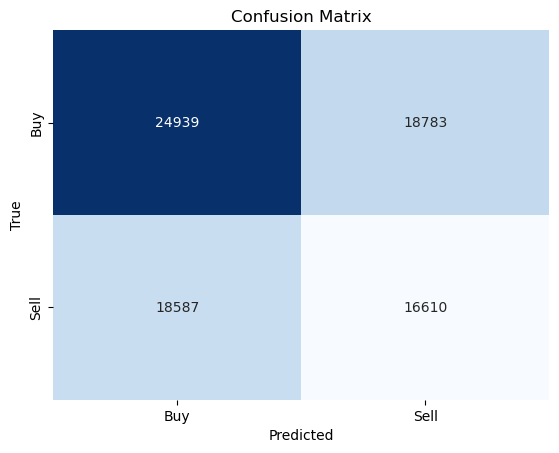

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the labels
labels = ['Buy', 'Sell']

# Sum the confusion matrices
total_confusion_matrix = np.sum(confusion_matrices, axis=0)

# Create the heatmap
sns.heatmap(total_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar= False)

# Set the labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [56]:
# Calculate the scores
calculate_scores(result_df, num_quarters=4, pos_label='Buy')

Accuracy: 0.4916030534351145
Balanced accuracy: 0.5267686371702909
Precision: 0.37637969094922735
Recall: 0.6492146596858639
F1 score: 0.4765065502183406
ROC AUC: 0.46109742154061234


In [129]:
returns_df = calculate_mean_returns(result_df, pos_label='Buy')


Running the full no buzzword model

In [130]:
# Define the model with the best parameters
model_nobuzz = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced',
                           n_jobs=-1, max_iter=10000, C=100) 

# Initialize lists to store the performance metrics
accuracies_nobuzz = []
balanced_accuracies_nobuzz = []
precisions_nobuzz = []
recalls_nobuzz = []
f1_scores_nobuzz = []
roc_aucs_nobuzz = []

# Initialize a list to store the coefficients
coefficients_nobuzz = []

# Initialize list to store the predictions
predictions_nobuzz = []

# Initialize a list to store the confusion matrices
confusion_matrices_nobuzz = []

# Iterate over the splits
for train_index, test_index in splits_full:
    # Split the data
    X_train, X_test = X_nobuzz_1_full.loc[train_index], X_nobuzz_1_full.loc[test_index]
    y_train, y_test = y_full.loc[train_index], y_full.loc[test_index]

    # Fit the model
    model_nobuzz.fit(X_train, y_train)

    # Predict the test set results
    y_pred = model_nobuzz.predict(X_test)
    y_pred_proba = model_nobuzz.predict_proba(X_test)

    predictions_nobuzz.extend([
        {'Index': index, 'Actual': actual, 'Predicted': predicted, 'Prob_0': prob_0, 'Prob_1': prob_1}
        for index, actual, predicted, (prob_0, prob_1) in zip(test_index, y_test, y_pred, y_pred_proba)
    ])

    # Calculate the performance metrics
    accuracies_nobuzz.append(accuracy_score(y_test, y_pred))
    balanced_accuracies_nobuzz.append(balanced_accuracy_score(y_test, y_pred))
    precisions_nobuzz.append(precision_score(y_test, y_pred, pos_label='Buy'))
    recalls_nobuzz.append(recall_score(y_test, y_pred, pos_label='Buy'))
    f1_scores_nobuzz.append(f1_score(y_test, y_pred, pos_label='Buy'))
    roc_aucs_nobuzz.append(roc_auc_score(y_test, model_nobuzz.predict_proba(X_test)[:, 1]))
    
    # Get the coefficients and append to the list
    coefficients_nobuzz.append(model_nobuzz.coef_[0])

    # Calculate the confusion matrix and append to the list
    confusion_matrices_nobuzz.append(confusion_matrix(y_test, y_pred))

# Convert the list of predictions to a DataFrame
predictions_nobuzz = pd.DataFrame(predictions_nobuzz)

# Set the index in predictions_nobuzz DataFrame
predictions_nobuzz.set_index('Index', inplace=True)

# Merge predictions_nobuzz with clean_df
result_df_nobuzz = clean_df.merge(predictions_nobuzz, left_index=True, right_index=True)

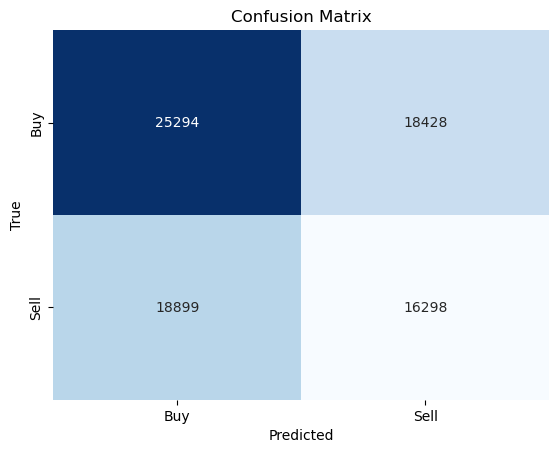

In [131]:
# Define the labels
labels = ['Buy', 'Sell']

# Sum the confusion matrices
total_confusion_matrix_nobuzz = np.sum(confusion_matrices_nobuzz, axis=0)


# Create the heatmap
sns.heatmap(total_confusion_matrix_nobuzz, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar= False)

# Set the labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [132]:
returns_df_nobuzz = calculate_mean_returns(result_df_nobuzz, pos_label='Buy')
calculate_scores(result_df_nobuzz, num_quarters=4, pos_label='Buy')

Accuracy: 0.48312128922815945
Balanced accuracy: 0.5207102599685819
Precision: 0.3716069489685125
Recall: 0.6515944788196097
F1 score: 0.4732929991356958
ROC AUC: 0.46147892022198933


No buzz no sentiment

In [150]:
# Define the model with the best parameters
model_base = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced',
                           n_jobs=-1, max_iter=10000, C=0.1) 

# Initialize lists to store the performance metrics
accuracies_base = []
balanced_accuracies_base = []
precisions_base = []
recalls_base = []
f1_scores_base = []
roc_aucs_base = []

# Initialize a list to store the coefficients
coefficients_base = []

# Initialize list to store the predictions
predictions_base= []

# Initialize a list to store the confusion matrices
confusion_matrices_base = []

# Iterate over the splits
for train_index, test_index in splits_full:
    # Split the data
    X_train, X_test = X_nosent_nobuzz_full.loc[train_index], X_nosent_nobuzz_full.loc[test_index]
    y_train, y_test = y_full.loc[train_index], y_full.loc[test_index]

    # Fit the model
    model_base.fit(X_train, y_train)

    # Predict the test set results
    y_pred = model_base.predict(X_test)
    y_pred_proba = model_base.predict_proba(X_test)

    predictions_base.extend([
        {'Index': index, 'Actual': actual, 'Predicted': predicted, 'Prob_0': prob_0, 'Prob_1': prob_1}
        for index, actual, predicted, (prob_0, prob_1) in zip(test_index, y_test, y_pred, y_pred_proba)
    ])

    # Calculate the performance metrics
    accuracies_base.append(accuracy_score(y_test, y_pred))
    balanced_accuracies_base.append(balanced_accuracy_score(y_test, y_pred))
    precisions_base.append(precision_score(y_test, y_pred, pos_label='Buy'))
    recalls_base.append(recall_score(y_test, y_pred, pos_label='Buy'))
    f1_scores_base.append(f1_score(y_test, y_pred, pos_label='Buy'))
    roc_aucs_base.append(roc_auc_score(y_test, y_pred_proba[:, 1]))
    
    # Get the coefficients and append to the list
    coefficients_base.append(model_base.coef_[0])

    # Calculate the confusion matrix and append to the list
    confusion_matrices_base.append(confusion_matrix(y_test, y_pred))

# Convert the list of predictions to a DataFrame
predictions_base = pd.DataFrame(predictions_base)

# Set the index in predictions_nobuzz DataFrame
predictions_base.set_index('Index', inplace=True)

# Merge predictions_nobuzz with clean_df
result_df_base = clean_df.merge(predictions_base, left_index=True, right_index=True)

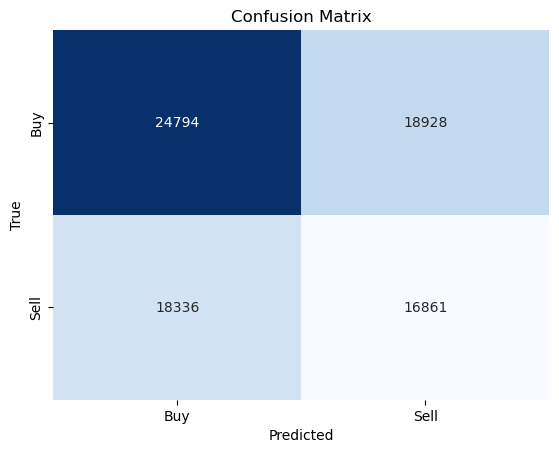

In [151]:
# Define the labels
labels = ['Buy', 'Sell']

# Sum the confusion matrices
total_confusion_matrix_base = np.sum(confusion_matrices_base, axis=0)

# Create the heatmap
sns.heatmap(total_confusion_matrix_base, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar= False)

# Set the labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [152]:
returns_df_base = calculate_mean_returns(result_df_base, pos_label='Buy')
calculate_scores(result_df_base, num_quarters=4, pos_label='Buy')

Accuracy: 0.4763358778625954
Balanced accuracy: 0.511297178314817
Precision: 0.36478332419089415
Recall: 0.6330318895763922
F1 score: 0.4628501827040195
ROC AUC: 0.46799036631149604


In [153]:
# Concatenate the 'datecqtr' columns from all three dataframes and get unique values
unique_datecqtr = pd.concat([result_df['datacqtr'], result_df_base['datacqtr'], result_df_nobuzz['datacqtr']]).unique()

# Initialize dictionaries to store accuracies
accuracies = {}
accuracies_base = {}
accuracies_nobuzz = {}

# Calculate accuracy for each unique 'datecqtr'
for date in unique_datecqtr:
    accuracies[date] = accuracy_score(result_df[result_df['datacqtr'] == date]['Actual'], result_df[result_df['datacqtr'] == date]['Predicted'])
    accuracies_base[date] = accuracy_score(result_df_base[result_df_base['datacqtr'] == date]['Actual'], result_df_base[result_df_base['datacqtr'] == date]['Predicted'])
    accuracies_nobuzz[date] = accuracy_score(result_df_nobuzz[result_df_nobuzz['datacqtr'] == date]['Actual'], result_df_nobuzz[result_df_nobuzz['datacqtr'] == date]['Predicted'])

# Convert dictionaries to lists for plotting
datecqtr_list = list(unique_datecqtr)
accuracies_list = [accuracies[date] for date in datecqtr_list]
accuracies_base_list = [accuracies_base[date] for date in datecqtr_list]
accuracies_nobuzz_list = [accuracies_nobuzz[date] for date in datecqtr_list]

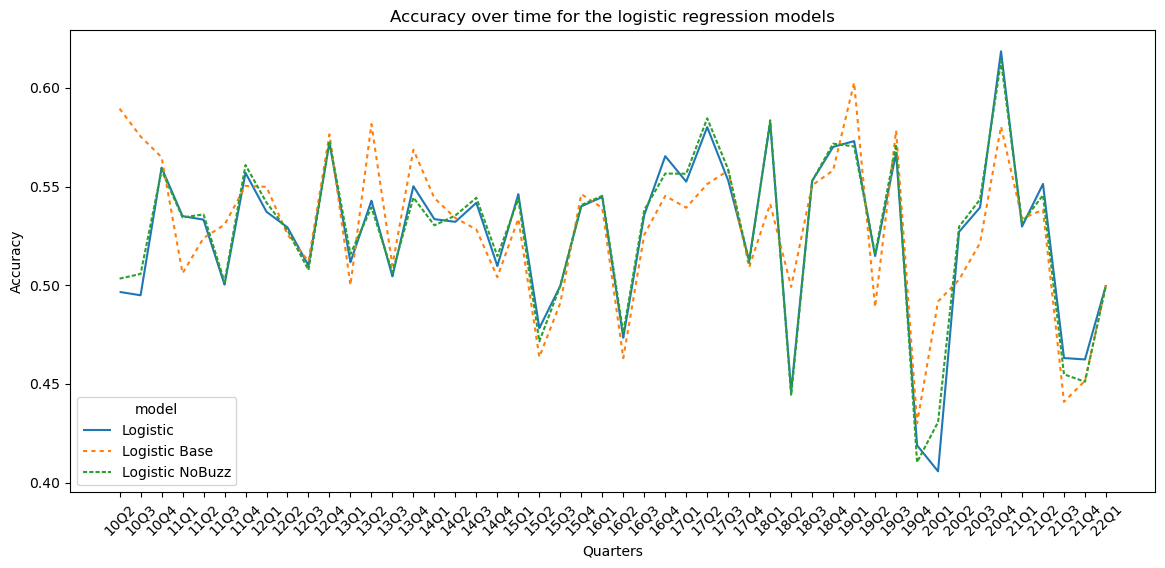

In [155]:
# Create a DataFrame for each model
df = pd.DataFrame({'datecqtr': datecqtr_list, 'accuracy': accuracies_list, 'model': 'Logistic'})
df_base = pd.DataFrame({'datecqtr': datecqtr_list, 'accuracy': accuracies_base_list, 'model': 'Logistic Base'})
df_nobuzz = pd.DataFrame({'datecqtr': datecqtr_list, 'accuracy': accuracies_nobuzz_list, 'model': 'Logistic NoBuzz'})

# Concatenate the dataframes
df = pd.concat([df, df_base, df_nobuzz])

# Function to transform datecqtr
def transform_datecqtr(date):
    year, quarter = date.split('Q')
    return f'{year[2:]}Q{quarter}'

# Apply the function to the 'datecqtr' column
df['datecqtr'] = df['datecqtr'].apply(transform_datecqtr)

plt.figure(figsize=(14, 6))

# Create a line plot
sns.lineplot(data=df, x='datecqtr', y='accuracy', hue='model', style='model', dashes=[(1, 0), (2, 2), (2, 1)])

# Add labels and title
plt.xlabel('Quarters')
plt.ylabel('Accuracy')
plt.title('Accuracy over time for the logistic regression models')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()

### Running the full Random Forest Model

In [66]:
splits_rf_full = []
unique_datacqtr = clean_df['datacqtr'].unique()

# Ensure there are at least 8 quarters
assert len(unique_datacqtr) >= 8, "Not enough quarters for splitting"

for i in range(0, len(unique_datacqtr)-7, 4):
    # Use all quarters up to i+4 for training
    train = clean_df[clean_df['datacqtr'].isin(unique_datacqtr[:i+4])]
    train_index = train.index.to_numpy()
    # Use the next 4 quarters for testing
    test = clean_df[clean_df['datacqtr'].isin(unique_datacqtr[i+4:i+8])]
    test_index = test.index.to_numpy()
    if not test.empty:  # Ensure there is data in the test set
        splits_rf_full.append((train_index, test_index))

In [67]:
# Define the model with the best parameters
model_rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-4,
                                  n_estimators=1500, max_depth=30, min_samples_split=2)

# Initialize lists to store the performance metrics
accuracies_rf = []
balanced_accuracies_rf = []
precisions_rf = []
recalls_rf = []
f1_scores_rf = []
roc_aucs_rf = []

# Initialize a list to store the confusion matrices
confusion_matrices_rf = []

# Initialize a list to store the predictions
predictions_rf = []

# Initialize a list to store the feature importances
feature_importances_rf = []

# Iterate over the splits
for train_index, test_index in splits_full:
    # Split the data
    X_train, X_test = X_ensemble_3_full.loc[train_index], X_ensemble_3_full.loc[test_index]
    y_train, y_test = y_full.loc[train_index], y_full.loc[test_index]

    # Fit the model
    model_rf.fit(X_train, y_train)

    # Predict the test set results
    y_pred = model_rf.predict(X_test)
    y_pred_proba = model_rf.predict_proba(X_test)

    predictions_rf.extend([
        {'Index': index, 'Actual': actual, 'Predicted': predicted, 'Prob_0': prob_0, 'Prob_1': prob_1}
        for index, actual, predicted, (prob_0, prob_1) in zip(test_index, y_test, y_pred, y_pred_proba)
    ])

    # Calculate the performance metrics
    accuracies_rf.append(accuracy_score(y_test, y_pred))
    balanced_accuracies_rf.append(balanced_accuracy_score(y_test, y_pred))
    precisions_rf.append(precision_score(y_test, y_pred, pos_label='Buy'))
    recalls_rf.append(recall_score(y_test, y_pred, pos_label='Buy'))
    f1_scores_rf.append(f1_score(y_test, y_pred, pos_label='Buy'))
    roc_aucs_rf.append(roc_auc_score(y_test, y_pred_proba[:, 1]))

    # Calculate the confusion matrix and append to the list
    confusion_matrices_rf.append(confusion_matrix(y_test, y_pred))

    # Get the feature importances and append to the list
    feature_importances_rf.append(model_rf.feature_importances_)

# Convert the list of predictions to a DataFrame
predictions_rf = pd.DataFrame(predictions_rf)

# Set the index in predictions_rf DataFrame
predictions_rf.set_index('Index', inplace=True)

# Merge predictions_rf with clean_df
result_df_rf = clean_df.merge(predictions_rf, left_index=True, right_index=True)

# Sum the confusion matrices
total_confusion_matrix_rf = np.sum(confusion_matrices_rf, axis=0)

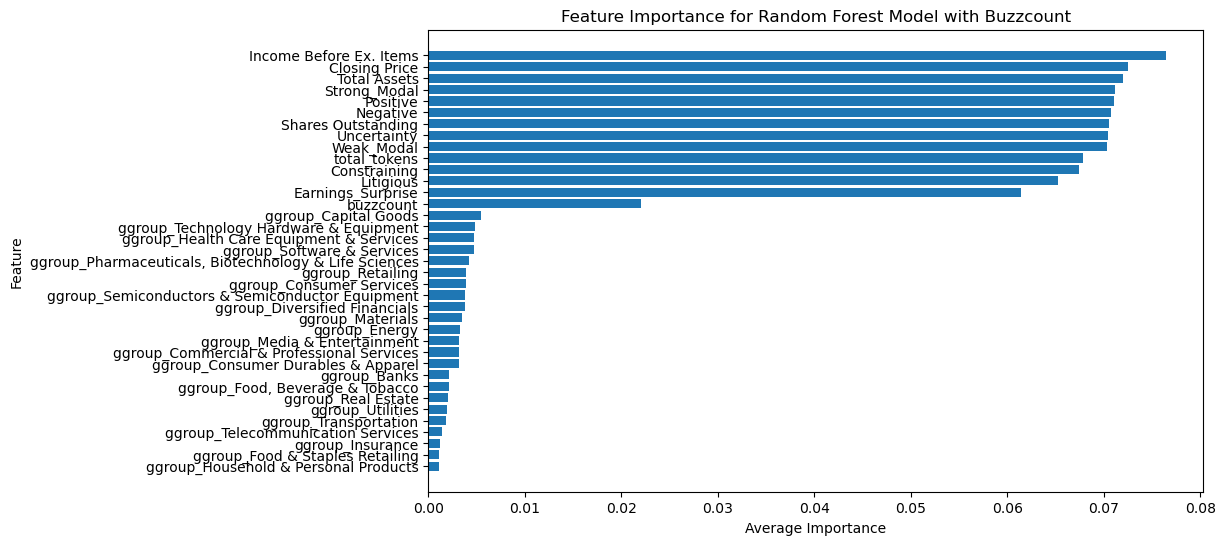

In [160]:
# Rename the features
X_ensemble_3_full = X_ensemble_3_full.rename(columns={
    'ibq': 'Income Before Ex. Items',
    'nonadjclose': 'Closing Price',
    'atq': 'Total Assets',
    'cshoc': 'Shares Outstanding'
})

# Calculate the average feature importances
average_feature_importances_rf = np.mean(feature_importances_rf, axis=0)

# Create a DataFrame for easier visualization
feature_importances_df_rf = pd.DataFrame({'Feature': X_ensemble_3_full.columns, 'Average Importance': average_feature_importances_rf})

# Sort the DataFrame by importance
feature_importances_df_rf.sort_values('Average Importance', ascending=False, inplace=True)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df_rf['Feature'], feature_importances_df_rf['Average Importance'])
plt.xlabel('Average Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model with Buzzcount')
plt.gca().invert_yaxis()
plt.show()

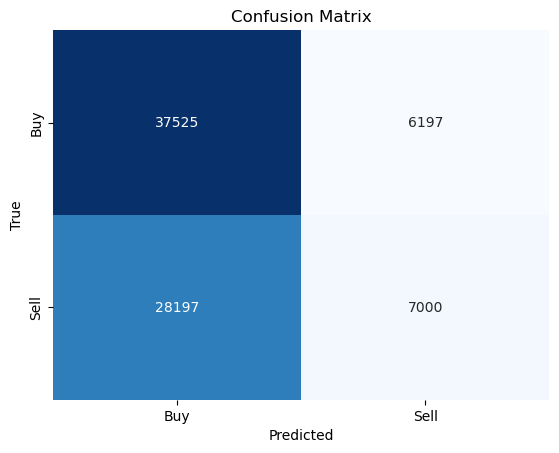

In [69]:
# Define the labels
labels = ['Buy', 'Sell']

# Create the heatmap
sns.heatmap(total_confusion_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar= False)

# Set the labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [156]:
returns_rf_df = calculate_mean_returns(result_df_rf, pos_label='Buy')
calculate_scores(result_df_rf, num_quarters=4, pos_label='Buy')

Accuracy: 0.4763358778625954
Balanced accuracy: 0.559934433912912
Precision: 0.39193336256028055
Recall: 0.8510233222275108
F1 score: 0.5366951823502926
ROC AUC: 0.40192209598712564


No buzz model

In [71]:
# Define the model with the best parameters
model_rf_nobuzz = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-4, verbose=1,
                                         n_estimators=1000, max_depth=30, min_samples_split=2)

# Initialize lists to store the performance metrics
accuracies_rf_nobuzz = []
balanced_accuracies_rf_nobuzz = []
precisions_rf_nobuzz = []
recalls_rf_nobuzz = []
f1_scores_rf_nobuzz = []
roc_aucs_rf_nobuzz = []

# Initialize a list to store the confusion matrices
confusion_matrices_rf_nobuzz = []

# Initialize a list to store the predictions
predictions_rf_nobuzz = []

# Initialize a list to store the feature importances
feature_importances_rf_nobuzz = []

# Iterate over the splits
for train_index, test_index in splits_full:
    # Split the data
    X_train, X_test = X_ensemble_nobuzz_1_full.loc[train_index], X_ensemble_nobuzz_1_full.loc[test_index]
    y_train, y_test = y_full.loc[train_index], y_full.loc[test_index]

    # Fit the model
    model_rf_nobuzz.fit(X_train, y_train)

    # Predict the test set results
    y_pred = model_rf_nobuzz.predict(X_test)
    y_pred_proba = model_rf_nobuzz.predict_proba(X_test)

    predictions_rf_nobuzz.extend([
        {'Index': index, 'Actual': actual, 'Predicted': predicted, 'Prob_0': prob_0, 'Prob_1': prob_1}
        for index, actual, predicted, (prob_0, prob_1) in zip(test_index, y_test, y_pred, y_pred_proba)
    ])

    # Calculate the performance metrics
    accuracies_rf_nobuzz.append(accuracy_score(y_test, y_pred))
    balanced_accuracies_rf_nobuzz.append(balanced_accuracy_score(y_test, y_pred))
    precisions_rf_nobuzz.append(precision_score(y_test, y_pred, pos_label='Buy'))
    recalls_rf_nobuzz.append(recall_score(y_test, y_pred, pos_label='Buy'))
    f1_scores_rf_nobuzz.append(f1_score(y_test, y_pred, pos_label='Buy'))
    roc_aucs_rf_nobuzz.append(roc_auc_score(y_test, y_pred_proba[:, 1]))

    # Calculate the confusion matrix and append to the list
    confusion_matrices_rf_nobuzz.append(confusion_matrix(y_test, y_pred))

    # Get the feature importances and append to the list
    feature_importances_rf_nobuzz.append(model_rf_nobuzz.feature_importances_)

# Convert the list of predictions to a DataFrame
predictions_rf_nobuzz = pd.DataFrame(predictions_rf_nobuzz)

# Set the index in predictions_rf DataFrame
predictions_rf_nobuzz.set_index('Index', inplace=True)

# Merge predictions_rf with clean_df
result_df_rf_nobuzz = clean_df.merge(predictions_rf_nobuzz, left_index=True, right_index=True)

# Sum the confusion matrices
total_confusion_matrix_rf_nobuzz = np.sum(confusion_matrices_rf_nobuzz, axis=0)

[Parallel(n_jobs=-4)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=-4)]: Done  32 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-4)]: Done 182 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-4)]: Done 432 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-4)]: Done 782 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-4)]: Done 1000 out of 1000 | elapsed:   16.2s finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 432 tasks      | elapsed:    0.1s
[Parallel(n_jobs=9)]: Done 782 tasks      | elapsed:    0.2s
[Parallel(n_jobs=9)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=9)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:    0.0s


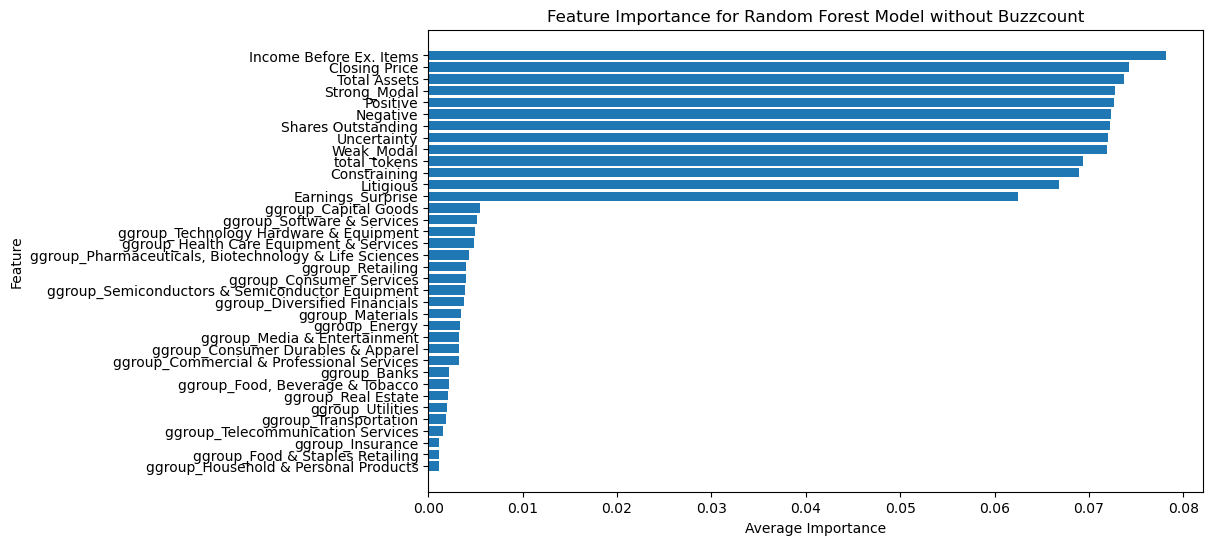

In [159]:
# Rename the features
X_ensemble_nobuzz_1_full = X_ensemble_nobuzz_1_full.rename(columns={
    'ibq': 'Income Before Ex. Items',
    'nonadjclose': 'Closing Price',
    'atq': 'Total Assets',
    'cshoc': 'Shares Outstanding'
})

# Recalculate the average feature importances
average_feature_importances_rf_nobuzz = np.mean(feature_importances_rf_nobuzz, axis=0)

# Create a DataFrame for easier visualization
feature_importances_df_rf_nobuzz = pd.DataFrame({'Feature': X_ensemble_nobuzz_1_full.columns, 'Average Importance': average_feature_importances_rf_nobuzz})

# Sort the DataFrame by importance
feature_importances_df_rf_nobuzz.sort_values('Average Importance', ascending=False, inplace=True)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df_rf_nobuzz['Feature'], feature_importances_df_rf_nobuzz['Average Importance'])
plt.xlabel('Average Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model without Buzzcount')
plt.gca().invert_yaxis()
plt.show()

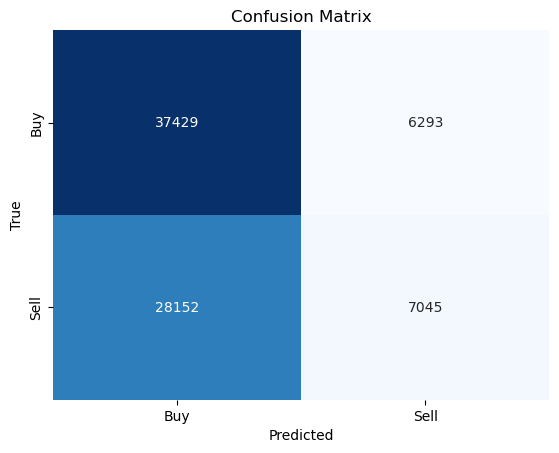

In [73]:
# Define the labels
labels = ['Buy', 'Sell']

# Create the heatmap
sns.heatmap(total_confusion_matrix_rf_nobuzz, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar= False)

# Set the labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [ ]:
returns_rf_nobuzz_df = calculate_mean_returns(result_df_rf_nobuzz, pos_label='Buy')
calculate_scores(result_df_rf_nobuzz, num_quarters=4, pos_label='Buy')

Accuracy: 0.4768447837150127
Balanced accuracy: 0.5600112103657244
Precision: 0.3920491983307709
Recall: 0.8495954307472632
F1 score: 0.5365193868349865
ROC AUC: 0.40126560713489096


No buzz no sent

In [75]:
# Define the model with the best parameters
model_rf_base = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-4,
                                       n_estimators=600, max_depth=10, min_samples_split=2)

# Initialize lists to store the performance metrics
accuracies_rf_base = []
balanced_accuracies_rf_base = []
precisions_rf_base = []
recalls_rf_base = []
f1_scores_rf_base = []
roc_aucs_rf_base = []

# Initialize a list to store the confusion matrices
confusion_matrices_rf_base = []

# Initialize a list to store the predictions
predictions_rf_base = []

# Initialize a list to store the feature importances
feature_importances_rf_base = []

# Iterate over the splits
for train_index, test_index in splits_full:
    # Split the data
    X_train, X_test = X_ensemble_nosent_nobuzz_full.loc[train_index], X_ensemble_nosent_nobuzz_full.loc[test_index]
    y_train, y_test = y_full.loc[train_index], y_full.loc[test_index]

    # Fit the model
    model_rf_base.fit(X_train, y_train)

    # Predict the test set results
    y_pred = model_rf_base.predict(X_test)
    y_pred_proba = model_rf_base.predict_proba(X_test)

    predictions_rf_base.extend([
        {'Index': index, 'Actual': actual, 'Predicted': predicted, 'Prob_0': prob_0, 'Prob_1': prob_1}
        for index, actual, predicted, (prob_0, prob_1) in zip(test_index, y_test, y_pred, y_pred_proba)
    ])

    # Calculate the performance metrics
    accuracies_rf_base.append(accuracy_score(y_test, y_pred))
    balanced_accuracies_rf_base.append(balanced_accuracy_score(y_test, y_pred))
    precisions_rf_base.append(precision_score(y_test, y_pred, pos_label='Buy'))
    recalls_rf_base.append(recall_score(y_test, y_pred, pos_label='Buy'))
    f1_scores_rf_base.append(f1_score(y_test, y_pred, pos_label='Buy'))
    roc_aucs_rf_base.append(roc_auc_score(y_test, y_pred_proba[:, 1]))

    # Calculate the confusion matrix and append to the list
    confusion_matrices_rf_base.append(confusion_matrix(y_test, y_pred))

    # Get the feature importances and append to the list
    feature_importances_rf_base.append(model_rf_base.feature_importances_)

# Convert the list of predictions to a DataFrame
predictions_rf_base = pd.DataFrame(predictions_rf_base)

# Set the index in predictions_rf DataFrame
predictions_rf_base.set_index('Index', inplace=True)

# Merge predictions_rf with clean_df
result_df_rf_base = clean_df.merge(predictions_rf_base, left_index=True, right_index=True)

# Sum the confusion matrices
total_confusion_matrix_rf_base = np.sum(confusion_matrices_rf_base, axis=0)

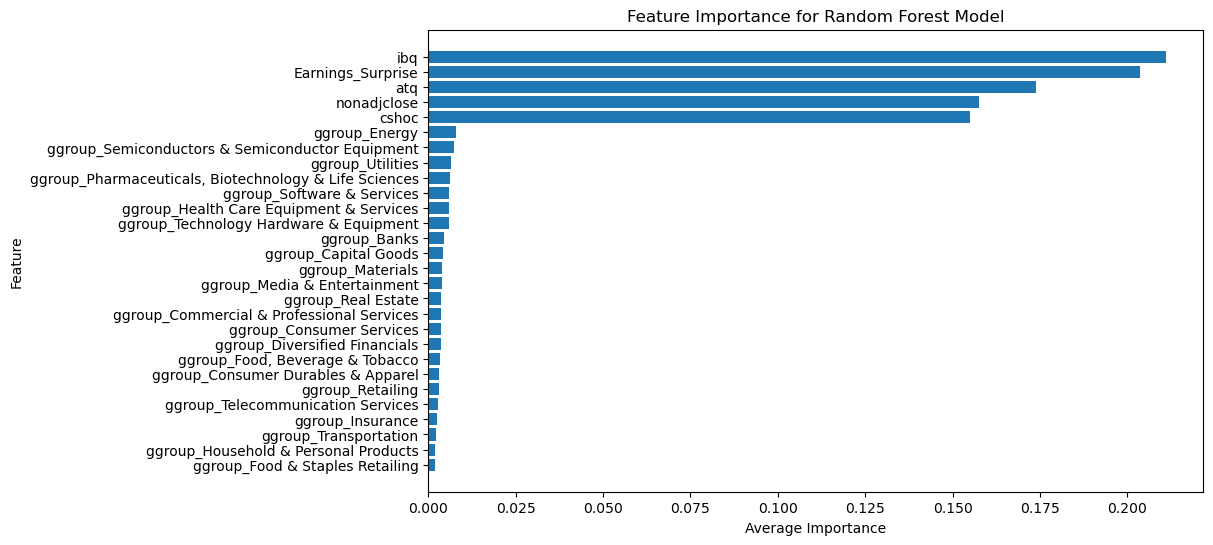

In [76]:
# Calculate the average feature importances
average_feature_importances_rf_base = np.mean(feature_importances_rf_base, axis=0)

# Create a DataFrame for easier visualization
feature_importances_df_rf_base = pd.DataFrame({'Feature': X_train.columns, 'Average Importance': average_feature_importances_rf_base})

# Sort the DataFrame by importance
feature_importances_df_rf_base.sort_values('Average Importance', ascending=False, inplace=True)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df_rf_base['Feature'], feature_importances_df_rf_base['Average Importance'])
plt.xlabel('Average Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

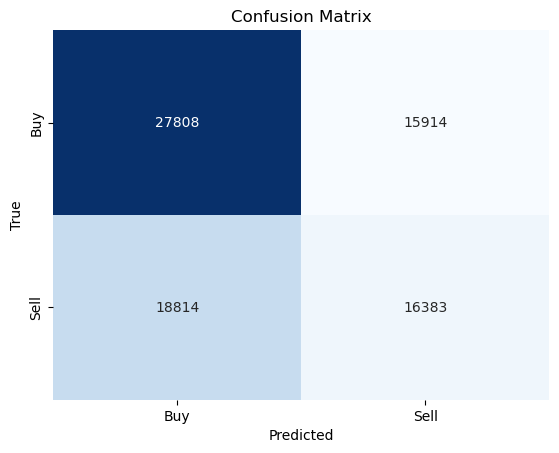

In [77]:
# Define the labels
labels = ['Buy', 'Sell']

# Create the heatmap
sns.heatmap(total_confusion_matrix_rf_base, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar= False)

# Set the labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [ ]:
returns_rf_base_df = calculate_mean_returns(result_df_rf_base, pos_label='Buy')
calculate_scores(result_df_rf_base, num_quarters=4, pos_label='Buy')

Accuracy: 0.549618320610687
Balanced accuracy: 0.5800168080214834
Precision: 0.41938300349243307
Recall: 0.6858638743455497
F1 score: 0.5204984648726747
ROC AUC: 0.4007417207509942


Plotting the over time performance

In [79]:
# Concatenate the 'datecqtr' columns from all three dataframes and get unique values
unique_datecqtr = pd.concat([result_df_rf['datacqtr'], result_df_rf_base['datacqtr'], result_df_rf_nobuzz['datacqtr']]).unique()

# Initialize dictionaries to store accuracies
accuracies_rf = {}
accuracies_rf_base = {}
accuracies_rf_nobuzz = {}

# Calculate accuracy for each unique 'datecqtr'
for date in unique_datecqtr:
    accuracies_rf[date] = accuracy_score(result_df_rf[result_df_rf['datacqtr'] == date]['Actual'], result_df_rf[result_df_rf['datacqtr'] == date]['Predicted'])
    accuracies_rf_base[date] = accuracy_score(result_df_rf_base[result_df_rf_base['datacqtr'] == date]['Actual'], result_df_rf_base[result_df_rf_base['datacqtr'] == date]['Predicted'])
    accuracies_rf_nobuzz[date] = accuracy_score(result_df_rf_nobuzz[result_df_rf_nobuzz['datacqtr'] == date]['Actual'], result_df_rf_nobuzz[result_df_rf_nobuzz['datacqtr'] == date]['Predicted'])

# Convert dictionaries to lists for plotting
datecqtr_list = list(unique_datecqtr)
accuracies_rf_list = [accuracies_rf[date] for date in datecqtr_list]
accuracies_rf_base_list = [accuracies_rf_base[date] for date in datecqtr_list]
accuracies_rf_nobuzz_list = [accuracies_rf_nobuzz[date] for date in datecqtr_list]

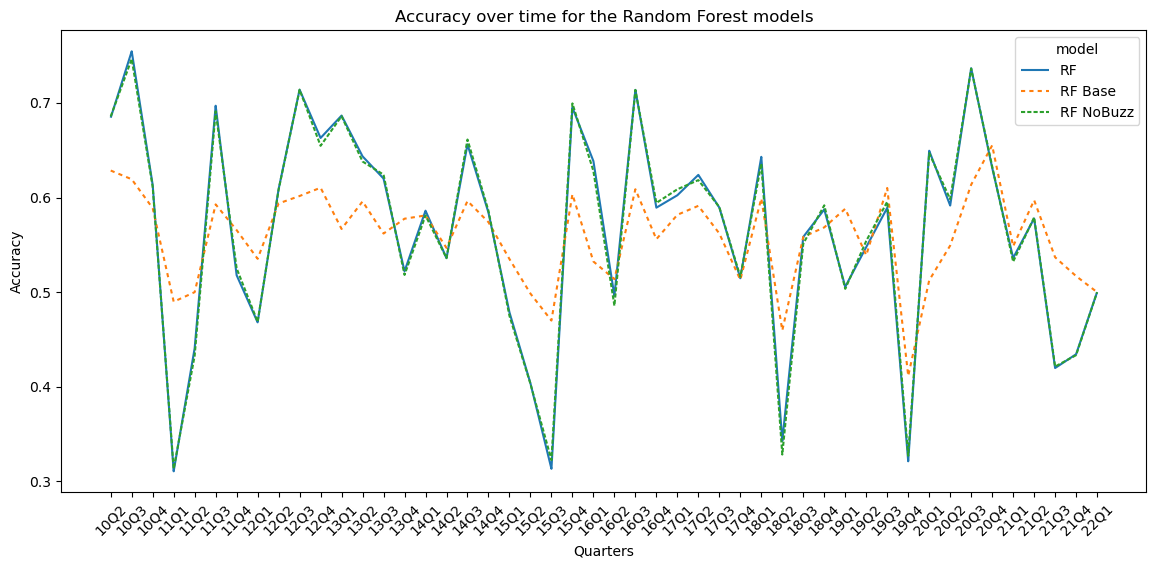

In [172]:
# Create a DataFrame for each model
df_rf = pd.DataFrame({'datecqtr': datecqtr_list, 'accuracy': accuracies_rf_list, 'model': 'RF'})
df_rf_base = pd.DataFrame({'datecqtr': datecqtr_list, 'accuracy': accuracies_rf_base_list, 'model': 'RF Base'})
df_rf_nobuzz = pd.DataFrame({'datecqtr': datecqtr_list, 'accuracy': accuracies_rf_nobuzz_list, 'model': 'RF NoBuzz'})

# Concatenate the dataframes
df = pd.concat([df_rf, df_rf_base, df_rf_nobuzz])

# Function to transform datecqtr
def transform_datecqtr(date):
    year, quarter = date.split('Q')
    return f'{year[2:]}Q{quarter}'

# Apply the function to the 'datecqtr' column
df['datecqtr'] = df['datecqtr'].apply(transform_datecqtr)

plt.figure(figsize=(14, 6))

# Create a line plot
sns.lineplot(data=df, x='datecqtr', y='accuracy', hue='model', style='model', dashes=[(1, 0), (2, 2), (2, 1)])

# Add labels and title
plt.xlabel('Quarters')
plt.ylabel('Accuracy')
plt.title('Accuracy over time for the Random Forest models')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [170]:
calculate_scores(result_df_rf, num_quarters=43434, pos_label='Buy')

Accuracy: 0.5641860641923998
Balanced accuracy: 0.5285720804077588
Precision: 0.5709655823012081
Recall: 0.8582635744019029
F1 score: 0.6857388253353313
ROC AUC: 0.447091624496833


In [169]:
calculate_scores(result_df_rf_nobuzz, num_quarters=44343, pos_label='Buy')

Accuracy: 0.5635398319796247
Balanced accuracy: 0.528113493957268
Precision: 0.5707293270916881
Recall: 0.8560678834454051
F1 score: 0.68486683805568
ROC AUC: 0.44759977026301145


In [168]:
calculate_scores(result_df_rf_base, num_quarters=44334, pos_label='Buy')

Accuracy: 0.5599538767597156
Balanced accuracy: 0.5507421435718884
Precision: 0.5964566084681052
Recall: 0.6360184803988839
F1 score: 0.6156025856725406
ROC AUC: 0.43564007923943626


In [167]:
calculate_scores(result_df, num_quarters=44343, pos_label='Buy')

Accuracy: 0.5264765138939925
Balanced accuracy: 0.521157280669938
Precision: 0.5729678812663695
Recall: 0.5703993412927131
F1 score: 0.5716807262057583
ROC AUC: 0.47049920098096276


In [166]:
calculate_scores(result_df_nobuzz, num_quarters=44343, pos_label='Buy')

Accuracy: 0.527021376347901
Balanced accuracy: 0.5207848258355903
Precision: 0.5723530875930577
Recall: 0.5785188234755958
F1 score: 0.5754194392310755
ROC AUC: 0.47049936603572096


In [165]:
calculate_scores(result_df_base, num_quarters=44343, pos_label='Buy')

Accuracy: 0.5278196631989762
Balanced accuracy: 0.5230647213614389
Precision: 0.5748666821238118
Recall: 0.5670829330771694
F1 score: 0.5709482798323585
ROC AUC: 0.469697168069868


In [162]:
calculate_scores(result_df_xg, num_quarters=44343, pos_label=0)

Accuracy: 0.5600932601781573
Balanced accuracy: 0.546618964268994
Precision: 0.5905917385968089
Recall: 0.6713553817300215
F1 score: 0.6283891547049442
ROC AUC: 0.44176219935345656


In [163]:
calculate_scores(result_df_xg_nobuzz, num_quarters=44343, pos_label=0)

Accuracy: 0.5592823021072238
Balanced accuracy: 0.5457264150686042
Precision: 0.589853878158101
Recall: 0.6712181510452404
F1 score: 0.6279112062048675
ROC AUC: 0.44198596909270116


In [164]:
calculate_scores(result_df_xg_base, num_quarters=44343, pos_label=0)

Accuracy: 0.5601692874973073
Balanced accuracy: 0.5474769913569674
Precision: 0.5916926145267314
Recall: 0.6649741548876995
F1 score: 0.6261967068350941
ROC AUC: 0.441096755103123


### Running the full XGBoost model

In [112]:
# Create a StandardScaler instance
scaler = StandardScaler()

# List of dataframes to scale
dfs = [X_ensemble_1_full, X_ensemble_2_full, X_ensemble_3_full, X_ensemble_4_full,
       X_ensemble_nobuzz_1_full, X_ensemble_nobuzz_2_full, X_ensemble_nosent_nobuzz_full]

# Exclude columns that are already proportions
exclude_cols = ['Positive', 'Negative', 'Uncertainty', 'Constraining', 'Litigious', 'Weak_Modal', 'Strong_Modal']

for df in dfs:
    # Select numeric columns excluding the specified ones
    numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in exclude_cols]
    df.loc[:, numeric_cols] = scaler.fit_transform(df.loc[:, numeric_cols])

In [113]:
# Count buy and sell samples
num_buy = sum(y_train_encoded == 0)
num_sell = sum(y_train_encoded == 1)

# Calculate scale_pos_weight
scale_pos_weight = num_buy / num_sell

In [114]:
splits_rf_full = []
unique_datacqtr = clean_df['datacqtr'].unique()

# Ensure there are at least 8 quarters
assert len(unique_datacqtr) >= 8, "Not enough quarters for splitting"

for i in range(0, len(unique_datacqtr)-7, 4):
    # Use all quarters up to i+4 for training
    train = clean_df[clean_df['datacqtr'].isin(unique_datacqtr[:i+4])]
    train_index = train.index.to_numpy()
    # Use the next 4 quarters for testing
    test = clean_df[clean_df['datacqtr'].isin(unique_datacqtr[i+4:i+8])]
    test_index = test.index.to_numpy()
    if not test.empty:  # Ensure there is data in the test set
        splits_rf_full.append((train_index, test_index))

In [115]:
# Define the model
model_xg = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss', n_jobs=-2, verbosity=2, 
                         random_state=42, n_estimators=300, max_depth=3, learning_rate=0.01, colsample_bytree=0.6)

# Initialize lists to store the performance metrics
accuracies_xg = []
balanced_accuracies_xg = []
precisions_xg = []
recalls_xg = []
f1_scores_xg = []
roc_aucs_xg = []

# Initialize a list to store the predictions
predictions_xg = []

# Initialize a list to store the confusion matrices
confusion_matrices_xg = []

# Iterate over the splits
for train_index, test_index in splits_rf_full:
    # Split the data
    X_train, X_test = X_ensemble_3_full.loc[train_index], X_ensemble_3_full.loc[test_index]
    y_train, y_test = y_full_encoded[train_index], y_full_encoded[test_index]

    # Fit the model
    model_xg.fit(X_train, y_train)

    # Predict the test set results
    y_pred = model_xg.predict(X_test)
    y_pred_proba = model_xg.predict_proba(X_test)

    predictions_xg.extend([
        {'Index': index, 'Actual': actual, 'Predicted': predicted, 'Prob_0': prob_0, 'Prob_1': prob_1}
        for index, actual, predicted, (prob_0, prob_1) in zip(test_index, y_test, y_pred, y_pred_proba)
    ])

    # Calculate the performance metrics
    accuracies_xg.append(accuracy_score(y_test, y_pred))
    balanced_accuracies_xg.append(balanced_accuracy_score(y_test, y_pred))
    precisions_xg.append(precision_score(y_test, y_pred, pos_label=1))
    recalls_xg.append(recall_score(y_test, y_pred, pos_label=1))
    f1_scores_xg.append(f1_score(y_test, y_pred, pos_label=1))
    roc_aucs_xg.append(roc_auc_score(y_test, y_pred_proba[:, 1]))
    
    # Calculate the confusion matrix and append to the list
    confusion_matrices_xg.append(confusion_matrix(y_test, y_pred))


total_confusion_matrix_xg = np.sum(confusion_matrices_xg, axis=0)

# Convert the list of predictions to a DataFrame
predictions_xg = pd.DataFrame(predictions_xg)

# Set the index in predictions_nobuzz DataFrame
predictions_xg.set_index('Index', inplace=True)

# Merge predictions_nobuzz with clean_df
result_df_xg = clean_df.merge(predictions_xg, left_index=True, right_index=True)

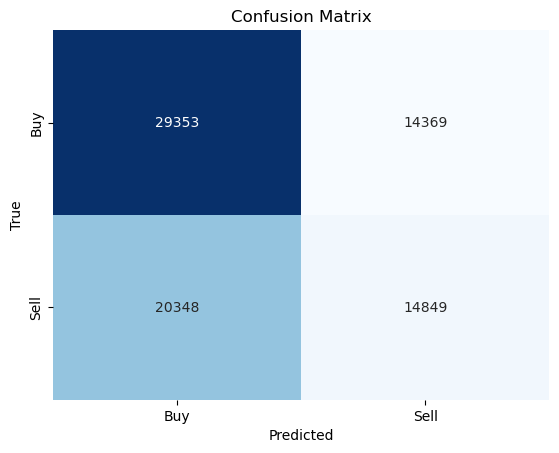

In [116]:
# Define the labels
labels = ['Buy', 'Sell']

# Create the heatmap
sns.heatmap(total_confusion_matrix_xg, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar= False)

# Set the labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [ ]:
returns_xg_df = calculate_mean_returns(result_df_xg, pos_label=0)
calculate_scores(result_df_xg, num_quarters=4, pos_label=0)

Accuracy: 0.5499575911789653
Balanced accuracy: 0.5785812639862987
Precision: 0.41887125220458554
Recall: 0.6782484531175631
F1 score: 0.5178993276394694
ROC AUC: 0.4094072983294598


No buzzword model

In [118]:
# Define the model
model_xg_nobuzz = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss', n_jobs=-2, verbosity=2, 
                         random_state=42, n_estimators=300, max_depth=3, learning_rate=0.01, colsample_bytree=0.6)

# Initialize lists to store the performance metrics
accuracies_xg_nobuzz = []
balanced_accuracies_xg_nobuzz = []
precisions_xg_nobuzz = []
recalls_xg_nobuzz = []
f1_scores_xg_nobuzz = []
roc_aucs_xg_nobuzz = []

# Initialize a list to store the predictions
predictions_xg_nobuzz = []

# Initialize a list to store the confusion matrices
confusion_matrices_xg_nobuzz = []

# Iterate over the splits
for train_index, test_index in splits_rf_full:
    # Split the data
    X_train, X_test = X_ensemble_nobuzz_1_full.loc[train_index], X_ensemble_nobuzz_1_full.loc[test_index]
    y_train, y_test = y_full_encoded[train_index], y_full_encoded[test_index]

    # Fit the model
    model_xg_nobuzz.fit(X_train, y_train)

    # Predict the test set results
    y_pred = model_xg_nobuzz.predict(X_test)
    y_pred_proba = model_xg_nobuzz.predict_proba(X_test)

    predictions_xg_nobuzz.extend([
        {'Index': index, 'Actual': actual, 'Predicted': predicted, 'Prob_0': prob_0, 'Prob_1': prob_1}
        for index, actual, predicted, (prob_0, prob_1) in zip(test_index, y_test, y_pred, y_pred_proba)
    ])

    # Calculate the performance metrics
    accuracies_xg_nobuzz.append(accuracy_score(y_test, y_pred))
    balanced_accuracies_xg_nobuzz.append(balanced_accuracy_score(y_test, y_pred))
    precisions_xg_nobuzz.append(precision_score(y_test, y_pred, pos_label=1))
    recalls_xg_nobuzz.append(recall_score(y_test, y_pred, pos_label=1))
    f1_scores_xg_nobuzz.append(f1_score(y_test, y_pred, pos_label=1))
    roc_aucs_xg_nobuzz.append(roc_auc_score(y_test, y_pred_proba[:, 1]))
    
    # Calculate the confusion matrix and append to the list
    confusion_matrices_xg_nobuzz.append(confusion_matrix(y_test, y_pred))


total_confusion_matrix_xg_nobuzz = np.sum(confusion_matrices_xg_nobuzz, axis=0)

# Convert the list of predictions to a DataFrame
predictions_xg_nobuzz = pd.DataFrame(predictions_xg_nobuzz)

# Set the index in predictions_nobuzz DataFrame
predictions_xg_nobuzz.set_index('Index', inplace=True)

# Merge predictions_nobuzz with clean_df
result_df_xg_nobuzz = clean_df.merge(predictions_xg_nobuzz, left_index=True, right_index=True)

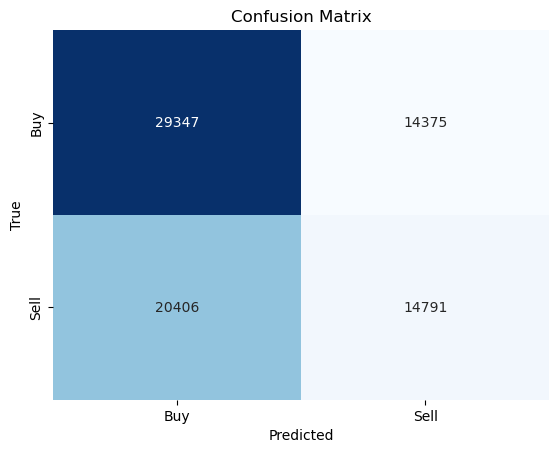

In [119]:
# Define the labels
labels = ['Buy', 'Sell']

# Create the heatmap
sns.heatmap(total_confusion_matrix_xg_nobuzz, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar= False)

# Set the labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [ ]:
returns_xg_nobuzz_df = calculate_mean_returns(result_df_xg_nobuzz, pos_label=0)
calculate_scores(result_df_xg_nobuzz, num_quarters=4, pos_label=0)

Accuracy: 0.5489397794741306
Balanced accuracy: 0.5780029315557995
Precision: 0.41822977725674093
Recall: 0.6792003807710614
F1 score: 0.5176854707056049
ROC AUC: 0.409444808393824


No buzz no sent

In [121]:
# Define the model
model_xg_base = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss', n_jobs=-2, verbosity=2, 
                         random_state=42, n_estimators=300, max_depth=3, learning_rate=0.01, colsample_bytree=0.8)

# Initialize lists to store the performance metrics
accuracies_xg_base = []
balanced_accuracies_xg_base = []
precisions_xg_base = []
recalls_xg_base = []
f1_scores_xg_base = []
roc_aucs_xg_base = []

# Initialize a list to store the predictions
predictions_xg_base = []

# Initialize a list to store the confusion matrices
confusion_matrices_xg_base = []

# Iterate over the splits
for train_index, test_index in splits_rf_full:
    # Split the data
    X_train, X_test = X_ensemble_nosent_nobuzz_full.loc[train_index], X_ensemble_nosent_nobuzz_full.loc[test_index]
    y_train, y_test = y_full_encoded[train_index], y_full_encoded[test_index]

    # Fit the model
    model_xg_base.fit(X_train, y_train)

    # Predict the test set results
    y_pred = model_xg_base.predict(X_test)
    y_pred_proba = model_xg_base.predict_proba(X_test)

    predictions_xg_base.extend([
        {'Index': index, 'Actual': actual, 'Predicted': predicted, 'Prob_0': prob_0, 'Prob_1': prob_1}
        for index, actual, predicted, (prob_0, prob_1) in zip(test_index, y_test, y_pred, y_pred_proba)
    ])

    # Calculate the performance metrics
    accuracies_xg_base.append(accuracy_score(y_test, y_pred))
    balanced_accuracies_xg_base.append(balanced_accuracy_score(y_test, y_pred))
    precisions_xg_base.append(precision_score(y_test, y_pred, pos_label=1))
    recalls_xg_base.append(recall_score(y_test, y_pred, pos_label=1))
    f1_scores_xg_base.append(f1_score(y_test, y_pred, pos_label=1))
    roc_aucs_xg_base.append(roc_auc_score(y_test, y_pred_proba[:, 1]))
    
    # Calculate the confusion matrix and append to the list
    confusion_matrices_xg_base.append(confusion_matrix(y_test, y_pred))


total_confusion_matrix_xg_base = np.sum(confusion_matrices_xg_base, axis=0)

# Convert the list of predictions to a DataFrame
predictions_xg_base = pd.DataFrame(predictions_xg_base)

# Set the index in predictions_base DataFrame
predictions_xg_base.set_index('Index', inplace=True)

# Merge predictions_base with clean_df
result_df_xg_base = clean_df.merge(predictions_xg_base, left_index=True, right_index=True)

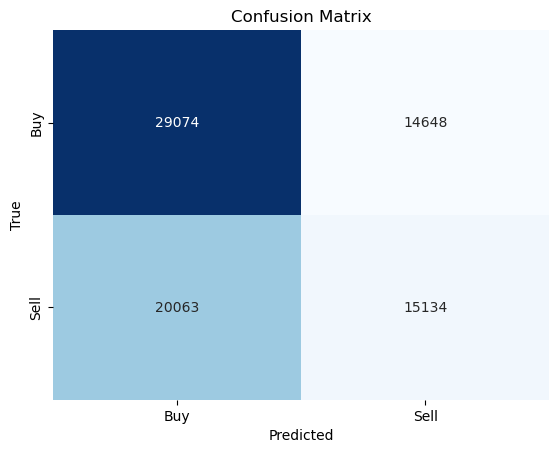

In [122]:
# Define the labels
labels = ['Buy', 'Sell']

# Create the heatmap
sns.heatmap(total_confusion_matrix_xg_base, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar= False)

# Set the labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [ ]:
returns_xg_base_df = calculate_mean_returns(result_df_xg_base, pos_label=0)
calculate_scores(result_df_xg_base, num_quarters=4, pos_label=0)

Accuracy: 0.5492790500424088
Balanced accuracy: 0.575611633589648
Precision: 0.4172619047619048
Recall: 0.6673012851023322
F1 score: 0.5134590734297748
ROC AUC: 0.408086981699354


In [124]:
# Concatenate the 'datecqtr' columns from all three dataframes and get unique values
unique_datecqtr = pd.concat([result_df_xg['datacqtr'], result_df_xg_base['datacqtr'], result_df_xg_nobuzz['datacqtr']]).unique()

# Initialize dictionaries to store accuracies
accuracies_xg = {}
accuracies_xg_base = {}
accuracies_xg_nobuzz = {}

# Calculate accuracy for each unique 'datecqtr'
for date in unique_datecqtr:
    accuracies_xg[date] = accuracy_score(result_df_xg[result_df_xg['datacqtr'] == date]['Actual'], result_df_xg[result_df_xg['datacqtr'] == date]['Predicted'])
    accuracies_xg_base[date] = accuracy_score(result_df_xg_base[result_df_xg_base['datacqtr'] == date]['Actual'], result_df_xg_base[result_df_xg_base['datacqtr'] == date]['Predicted'])
    accuracies_xg_nobuzz[date] = accuracy_score(result_df_xg_nobuzz[result_df_xg_nobuzz['datacqtr'] == date]['Actual'], result_df_xg_nobuzz[result_df_xg_nobuzz['datacqtr'] == date]['Predicted'])

# Convert dictionaries to lists for plotting
datecqtr_list = list(unique_datecqtr)
accuracies_xg_list = [accuracies_xg[date] for date in datecqtr_list]
accuracies_xg_base_list = [accuracies_xg_base[date] for date in datecqtr_list]
accuracies_xg_nobuzz_list = [accuracies_xg_nobuzz[date] for date in datecqtr_list]

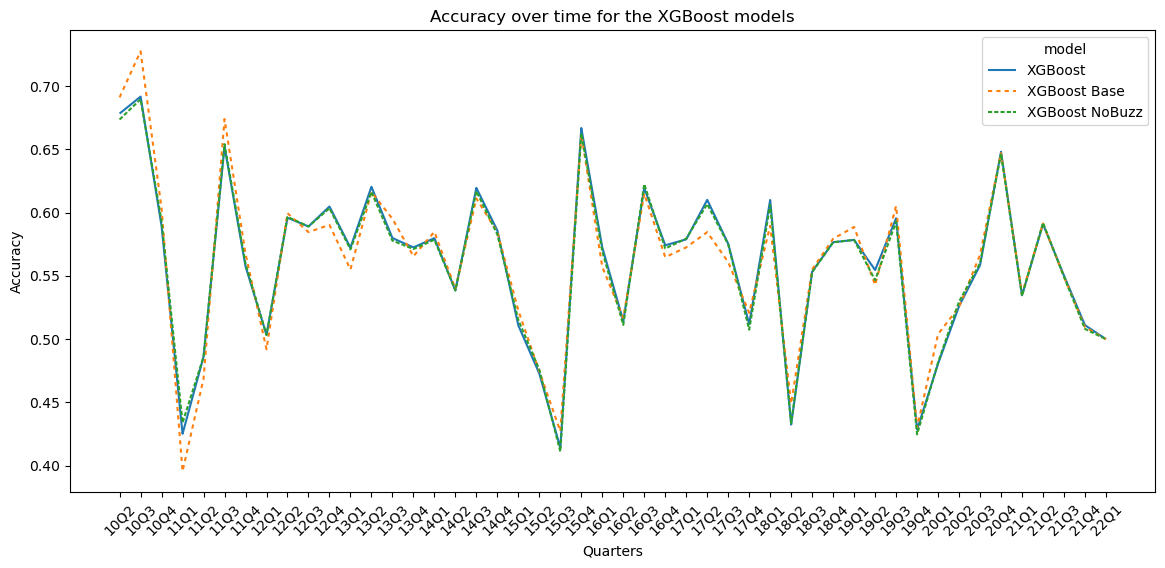

In [171]:
# Create a DataFrame for each model
df = pd.DataFrame({'datecqtr': datecqtr_list, 'accuracy': accuracies_xg_list, 'model': 'XGBoost'})
df_base = pd.DataFrame({'datecqtr': datecqtr_list, 'accuracy': accuracies_xg_base_list, 'model': 'XGBoost Base'})
df_nobuzz = pd.DataFrame({'datecqtr': datecqtr_list, 'accuracy': accuracies_xg_nobuzz_list, 'model': 'XGBoost NoBuzz'})

# Concatenate the dataframes
df = pd.concat([df, df_base, df_nobuzz])

# Function to transform datecqtr
def transform_datecqtr(date):
    year, quarter = date.split('Q')
    return f'{year[2:]}Q{quarter}'

# Apply the function to the 'datecqtr' column
df['datecqtr'] = df['datecqtr'].apply(transform_datecqtr)

plt.figure(figsize=(14, 6))

# Create a line plot
sns.lineplot(data=df, x='datecqtr', y='accuracy', hue='model', style='model', dashes=[(1, 0), (2, 2), (2, 1)])

# Add labels and title
plt.xlabel('Quarters')
plt.ylabel('Accuracy')
plt.title('Accuracy over time for the XGBoost models')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()

# Additional code

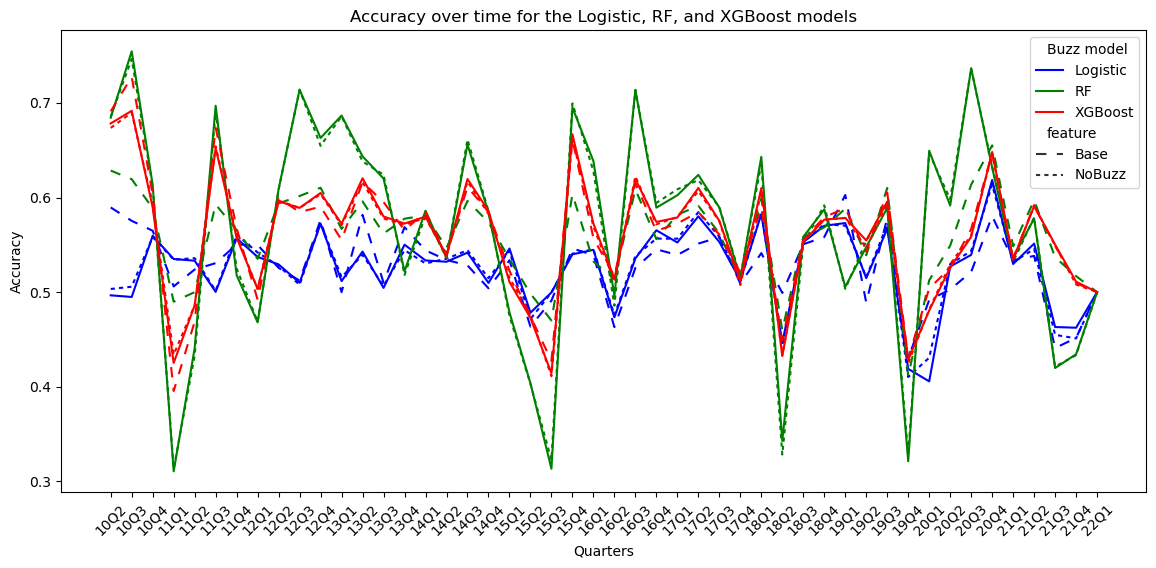

In [177]:
# Create a DataFrame for each model
df_logistic = pd.DataFrame({'datecqtr': datecqtr_list, 'accuracy': accuracies_list, 'model': 'Logistic'})
df_logistic_base = pd.DataFrame({'datecqtr': datecqtr_list, 'accuracy': accuracies_base_list, 'model': 'Logistic Base'})
df_logistic_nobuzz = pd.DataFrame({'datecqtr': datecqtr_list, 'accuracy': accuracies_nobuzz_list, 'model': 'Logistic NoBuzz'})

df_rf = pd.DataFrame({'datecqtr': datecqtr_list, 'accuracy': accuracies_rf_list, 'model': 'RF'})
df_rf_base = pd.DataFrame({'datecqtr': datecqtr_list, 'accuracy': accuracies_rf_base_list, 'model': 'RF Base'})
df_rf_nobuzz = pd.DataFrame({'datecqtr': datecqtr_list, 'accuracy': accuracies_rf_nobuzz_list, 'model': 'RF NoBuzz'})

df_xg = pd.DataFrame({'datecqtr': datecqtr_list, 'accuracy': accuracies_xg_list, 'model': 'XGBoost'})
df_xg_base = pd.DataFrame({'datecqtr': datecqtr_list, 'accuracy': accuracies_xg_base_list, 'model': 'XGBoost Base'})
df_xg_nobuzz = pd.DataFrame({'datecqtr': datecqtr_list, 'accuracy': accuracies_xg_nobuzz_list, 'model': 'XGBoost NoBuzz'})

# Concatenate the dataframes
df = pd.concat([df_logistic, df_logistic_base, df_logistic_nobuzz, df_rf, df_rf_base, df_rf_nobuzz, df_xg, df_xg_base, df_xg_nobuzz])

# Function to transform datecqtr
def transform_datecqtr(date):
    year, quarter = date.split('Q')
    return f'{year[2:]}Q{quarter}'

# Apply the function to the 'datecqtr' column
df['datecqtr'] = df['datecqtr'].apply(transform_datecqtr)

# Create a dictionary for colors and dashes
color_dict = {'Logistic': 'blue', 'RF': 'green', 'XGBoost': 'red'}
dash_dict = {'': "", 'Base': (5, 5), 'NoBuzz': (2, 2)}

# Create a new column for the base model
df['Buzz model'] = df['model'].str.split(' ').str[0]

# Create a new column for the feature
df['feature'] = df['model'].str.split(' ').str[1].fillna('')

plt.figure(figsize=(14, 6))

# Create a line plot
sns.lineplot(data=df, x='datecqtr', y='accuracy', hue='Buzz model', style='feature', palette=color_dict, dashes=dash_dict)

# Add labels and title
plt.xlabel('Quarters')
plt.ylabel('Accuracy')
plt.title('Accuracy over time for the Logistic, RF, and XGBoost models')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [180]:
returns_df = calculate_mean_returns(result_df, pos_label='Buy')
returns_df_nobuzz = calculate_mean_returns(result_df_nobuzz, pos_label='Buy')
returns_df_base = calculate_mean_returns(result_df_base, pos_label='Buy')



returns_rf_df = calculate_mean_returns(result_df_rf, pos_label='Buy')
returns_rf_nobuzz_df = calculate_mean_returns(result_df_rf_nobuzz, pos_label='Buy')
returns_rf_base_df = calculate_mean_returns(result_df_rf_base, pos_label='Buy')
returns_xg_df = calculate_mean_returns(result_df_xg, pos_label=0)
returns_xg_nobuzz_df = calculate_mean_returns(result_df_xg_nobuzz, pos_label=0)
returns_xg_base_df = calculate_mean_returns(result_df_xg_base, pos_label=0)

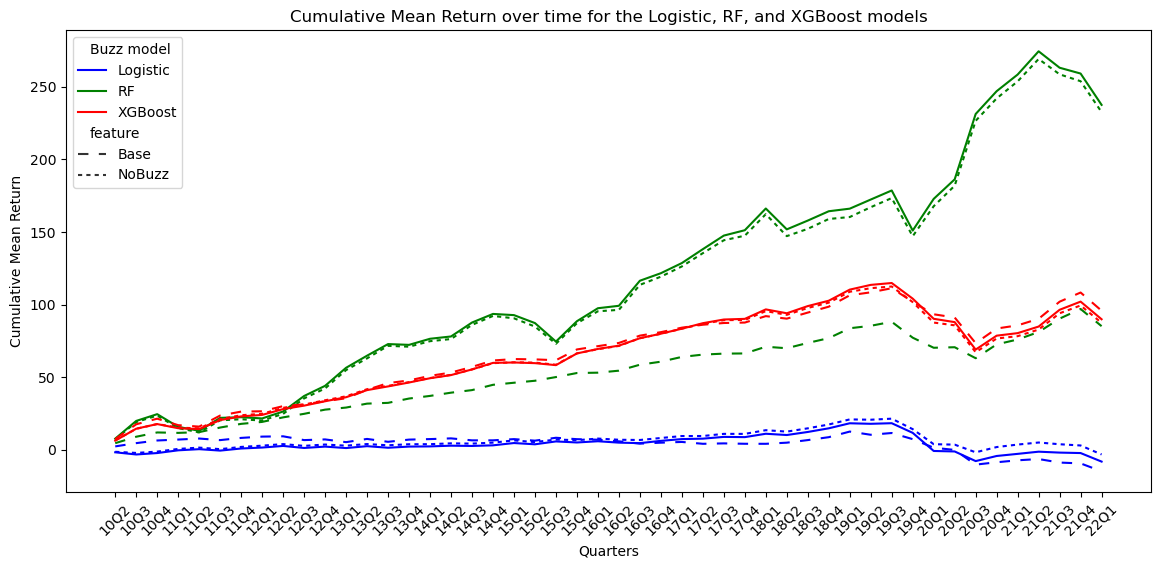

In [182]:
# Create a DataFrame for each model
df_logistic = returns_df[['datacqtr', 'Cumulative_Mean_Return']].copy()
df_logistic['model'] = 'Logistic'

df_logistic_base = returns_df_base[['datacqtr', 'Cumulative_Mean_Return']].copy()
df_logistic_base['model'] = 'Logistic Base'

df_logistic_nobuzz = returns_df_nobuzz[['datacqtr', 'Cumulative_Mean_Return']].copy()
df_logistic_nobuzz['model'] = 'Logistic NoBuzz'

df_rf = returns_rf_df[['datacqtr', 'Cumulative_Mean_Return']].copy()
df_rf['model'] = 'RF'

df_rf_base = returns_rf_base_df[['datacqtr', 'Cumulative_Mean_Return']].copy()
df_rf_base['model'] = 'RF Base'

df_rf_nobuzz = returns_rf_nobuzz_df[['datacqtr', 'Cumulative_Mean_Return']].copy()
df_rf_nobuzz['model'] = 'RF NoBuzz'

df_xg = returns_xg_df[['datacqtr', 'Cumulative_Mean_Return']].copy()
df_xg['model'] = 'XGBoost'

df_xg_base = returns_xg_base_df[['datacqtr', 'Cumulative_Mean_Return']].copy()
df_xg_base['model'] = 'XGBoost Base'

df_xg_nobuzz = returns_xg_nobuzz_df[['datacqtr', 'Cumulative_Mean_Return']].copy()
df_xg_nobuzz['model'] = 'XGBoost NoBuzz'

# Concatenate the dataframes
df = pd.concat([df_logistic, df_logistic_base, df_logistic_nobuzz, df_rf, df_rf_base, df_rf_nobuzz, df_xg, df_xg_base, df_xg_nobuzz])

# Function to transform datacqtr
def transform_datacqtr(date):
    year, quarter = date.split('Q')
    return f'{year[2:]}Q{quarter}'

# Apply the function to the 'datacqtr' column
df['datacqtr'] = df['datacqtr'].apply(transform_datacqtr)

# Create a dictionary for colors and dashes
color_dict = {'Logistic': 'blue', 'RF': 'green', 'XGBoost': 'red'}
dash_dict = {'': "", 'Base': (5, 5), 'NoBuzz': (2, 2)}

# Create a new column for the base model
df['Buzz model'] = df['model'].str.split(' ').str[0]

# Create a new column for the feature
df['feature'] = df['model'].str.split(' ').str[1].fillna('')

plt.figure(figsize=(14, 6))

# Create a line plot
sns.lineplot(data=df, x='datacqtr', y='Cumulative_Mean_Return', hue='Buzz model', style='feature', palette=color_dict, dashes=dash_dict)

# Add labels and title
plt.xlabel('Quarters')
plt.ylabel('Cumulative Mean Return')
plt.title('Cumulative Mean Return over time for the Logistic, RF, and XGBoost models')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [187]:
calculate_annualized_return(returns_rf_df)

10.669948424540166

In [188]:
calculate_annualized_return(returns_rf_nobuzz_df)

10.533244255213003

#### Checking the distribution of the target variable

In [ ]:
# Checking the distribution year by year
distribution = clean_df.groupby('datacqtr')['Target'].value_counts(normalize=True)

# Print the distribution
print(distribution)

datacqtr  Target
2009Q1    Buy       0.750000
          Sell      0.250000
2009Q2    Buy       0.583445
          Sell      0.258412
          Hold      0.158143
                      ...   
2021Q4    Hold      0.192021
2022Q1    Hold      0.983372
          Sell      0.009700
          Buy       0.006928
2022Q2    Hold      1.000000
Name: proportion, Length: 159, dtype: float64


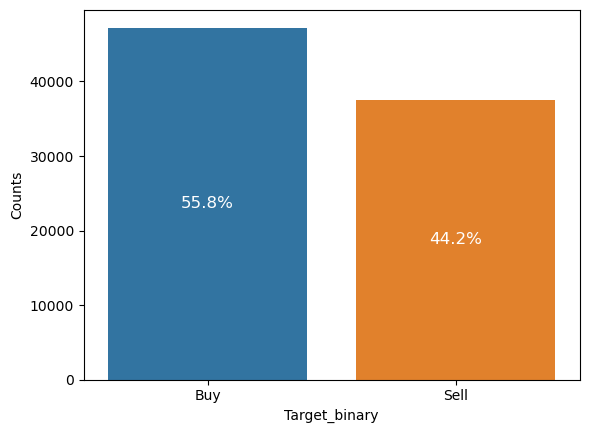

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
# Drop missing data
temp_df = clean_df.dropna(subset=['Target_binary'])

# Calculate the counts and percentages of each category
target_counts = temp_df['Target_binary'].value_counts()
target_percentage = temp_df['Target_binary'].value_counts(normalize=True) * 100

# Create a bar plot for the counts
ax = sns.barplot(x=target_counts.index, y=target_counts.values)
ax.set_ylabel('Counts')

# Add the percentage values inside the bars
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height / 2,
            f'{target_percentage.values[i]:.1f}%',
            ha='center', va='center', color='white', fontsize=12)

plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Drop missing data
temp_df = train_df.dropna(subset=['Target_binary'])

# Calculate the counts and percentages of each category
target_counts = temp_df['Target_binary'].value_counts()
target_percentage = temp_df['Target_binary'].value_counts(normalize=True) * 100

# Create a bar plot for the counts
ax = sns.barplot(x=target_counts.index, y=target_counts.values)
ax.set_ylabel('Counts')

# Add the percentage values inside the bars
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height / 2,
            f'{target_percentage.values[i]:.1f}%',
            ha='center', va='center', color='white', fontsize=12)

plt.show()

In [39]:
temp = result_df_xg[['datacqtr', 'Actual', 'Pct_Change_Next_Quarter']].copy()
temp['Predicted'] = 0
temp['Prob_0'] = 1

In [ ]:
calculate_scores(temp, num_quarters=4, pos_label=0)

Accuracy: 0.3552196504487482
Balanced accuracy: 0.5
Precision: 0.3552196504487482
Recall: 1.0
F1 score: 0.524224468455908
ROC AUC: 0.5


In [40]:
calculate_mean_returns(temp, pos_label=0)

,datacqtr,Mean_Return,Cumulative_Mean_Return
0,2010Q2,10.288476,10.288476
1,2010Q3,14.044688,24.333164
2,2010Q4,4.131199,28.464363
3,2011Q1,-8.611773,19.852590
4,2011Q2,-4.964786,14.887804
5,2011Q3,11.410109,26.297913
6,2011Q4,0.041877,26.339791
7,2012Q1,-2.708373,23.631418
8,2012Q2,3.111933,26.743350
9,2012Q3,11.601345,38.344695


In [89]:
filtered_df = results_df[results_df['tic'] == 'RKDA']

      datacqtr    Doc_id  Negative  Positive  Uncertainty  Litigious  \
42019   2015Q4   5931556  0.179856  0.467626     0.100719   0.093525   
45102   2016Q2   6062595  0.202797  0.391608     0.118881   0.069930   
46520   2016Q3   6134735  0.107692  0.392308     0.123077   0.176923   
48515   2016Q4   8852515  0.179487  0.358974     0.128205   0.162393   
50558   2017Q1  10360523  0.160000  0.460000     0.130000   0.070000   
52357   2017Q2  10751614  0.149533  0.542056     0.074766   0.102804   
54212   2017Q3  11059090  0.111111  0.452381     0.134921   0.095238   
59217   2018Q2  11673742  0.260000  0.380000     0.070000   0.040000   
61081   2018Q3  12142134  0.198630  0.390411     0.150685   0.054795   
63509   2018Q4  12427690  0.186047  0.470930     0.075581   0.110465   
65702   2019Q1  12529246  0.282609  0.434783     0.065217   0.065217   
67686   2019Q2  12646536  0.117117  0.450450     0.135135   0.099099   
69418   2019Q3  12849251  0.119048  0.412698     0.095238   0.07